In [1]:
# System modules
import os
import sys
from dotenv import load_dotenv
import logging
import requests
from hashlib import md5
import json

# ML modules
import pandas as pd
import numpy as np

# Viz modules
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px


# Append source directory to system path
src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

# Helper functions
import data.helpers as data_helpers
import visualization.helpers as viz_helpers


load_dotenv()  # take environment variables from .env.

YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")


In [2]:
def yelp_business_search_by_location(
    location: str = "Paris", count: int = 200
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Get Yelp data from API.

    Params:
        location: str
        count: int

    Returns:
        json
    """
    headers = {
        "Authorization": f"Bearer {YELP_API_KEY}",
    }
    limit = 50

    businesses = pd.DataFrame()
    reviews = pd.DataFrame()
    photos = pd.DataFrame()
    for offset in range(0, count, limit):
        businesses_request = requests.get(
            "https://api.yelp.com/v3/businesses/search",
            headers=headers,
            params={
                "location": location,
                "limit": limit,
                "offset": offset,
            },
        )

        if businesses_request.status_code == 200:
            businesses_data = businesses_request.json()
            businesses = businesses.append(
                pd.DataFrame(businesses_data["businesses"]), ignore_index=True
            )

            for business in businesses_data["businesses"]:
                business_detail_request = requests.get(
                    f"https://api.yelp.com/v3/businesses/{business['id']}",
                    headers=headers,
                )
                if business_detail_request.status_code == 200:
                    business_detail_data = business_detail_request.json()
                    photos = photos.append(
                        pd.DataFrame(business_detail_data["photos"]),
                        ignore_index=True,
                    )
                else:
                    raise Exception(
                        f"Yelp API request failed with status code \
                             { business_detail_request.status_code }. \
                                 Response text: { business_detail_request.text }"
                    )

            for business in businesses_data["businesses"]:
                business_reviews_request = requests.get(
                    f"https://api.yelp.com/v3/businesses/{business['id']}/reviews",
                    headers=headers,
                )
                if business_reviews_request.status_code == 200:
                    business_reviews_data = business_reviews_request.json()
                    reviews = reviews.append(
                        pd.DataFrame(business_reviews_data["reviews"]),
                        ignore_index=True,
                    )
                else:
                    raise Exception(
                        f"Yelp API request failed with status code { business_reviews_request.status_code }. Response text: { business_reviews_request.text }"
                    )

        else:
            raise Exception(
                f"Yelp API request failed with status code { businesses_request.status_code }. Response text: { businesses_request.text }"
            )

    return businesses, reviews, photos


In [3]:
def get_yelp_data(
    locations: list[str] = [
        "Paris",
        "New York City",
        "Tokyo",
        "Rio de Janeiro",
        "Sydney",
    ],
    category: str = "restaurants",
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Get Yelp data from API.

    - iterate over the locations
        - build a GraphQL query to get the data
        - send the query to the Yelp API
        - parse the response
        - append to the dataframe
    - return the dataframes

    Params:
        locations: str[] (default: ["Paris"]) - List of Yelp locations to search
        category: str (default: "restaurants") - Yelp category (see https://www.yelp.com/developers/documentation/v3/all_category_list)

    Returns:
        businesses: pd.DataFrame - businesses data from Yelp API request
        reviews: pd.DataFrame - reviews data from Yelp API request
        photos: pd.DataFrame - photos data from Yelp API request
    """
    # businesses data (see https://www.yelp.com/developers/graphql/objects/business)
    businesses = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of this business.
            "business_review_count",  # Total number of reviews for this business.
            "business_rating",  # Rating of the business, which is an average of the ratings of all reviews.
            "business_price",  # Price range of the business, from "$" to "$$$$" (inclusive).
            "business_city",  # City of this business.
            "business_state",  # ISO 3166-2 (with a few exceptions) state code of this business (see https://www.yelp.com/developers/documentation/v3/state_codes).
            "business_postal_code",  # Postal code of this business (see https://en.wikipedia.org/wiki/Postal_code)
            "business_country",  # ISO 3166-1 alpha-2 country code of this business.
            "business_latitude",  # Latitude of the business.
            "business_longitude",  # Longitude of the business.
            "business_categories",  # List of categories the business belongs to.
            "business_parent_categories",  # List of parent categories the business belongs to.
        ]
    )
    reviews = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of the business.
            "review_text",  # Text excerpt of this review.
            "review_rating",  # Rating of this review.
        ]
    )
    photos = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of the business.
            "photo_url",  # URL of the photo.
        ]
    )

    # Yelp's GraphQL endpoint
    url = "https://api.yelp.com/v3/graphql"
    # Request headers
    headers = {
        "Authorization": f"Bearer {YELP_API_KEY}",
        "Content-Type": "application/graphql",
    }
    count = 200  # Yelp's GraphQL API returns a maximum of 240 total results
    limit = 50  # Yelp's GraphQL API returns a maximum of 50 results per request

    for location in locations:
        for offset in range(0, count, limit):
            # Build the GraphQL query
            query = f'{{\n\
        search(categories: "{ category }", location: "{ location }", offset: { offset }, limit:  { limit }) {{\n\
            business {{\n\
                alias\n\
                review_count\n\
                rating\n\
                price\n\
                location {{\n\
                    city\n\
                    state\n\
                    postal_code\n\
                    country\n\
                }}\n\
                coordinates {{\n\
                    latitude\n\
                    longitude\n\
                }}\n\
                categories {{\n\
                    alias\n\
                    parent_categories {{\n\
                        alias\n\
                    }}\n\
                }}\n\
                photos\n\
                reviews {{\n\
                    text\n\
                    rating\n\
                }}\n\
            }}\n\
        }}\n\
    }}'
            # Send the query to the Yelp API
            response = requests.post(url, headers=headers, data=query)
            # Parse the response
            if not response.status_code == 200:
                raise Exception(
                    f"Yelp API request failed with status code { response.status_code }. Response text: { response.text }"
                )

            # Parse the response
            data = response.json()

            if "errors" in data:
                raise Exception(
                    f"Yelp API request failed with errors: { data['errors'] }"
                )

            for business in (
                data.get("data", {}).get("search", {}).get("business", [])
            ):
                # Add the business data to the dataframe
                businesses = businesses.append(
                    {
                        "business_alias": business.get("alias"),
                        "business_review_count": business.get("review_count"),
                        "business_rating": business.get("rating"),
                        "business_price": len(  # count the number of characters ($, €, ...)
                            business.get("price")
                        )
                        if business.get("price") is not None
                        else 0,
                        "business_city": business.get("location", {}).get(
                            "city"
                        ),
                        "business_state": business.get("location", {}).get(
                            "state"
                        ),
                        "business_postal_code": business.get(
                            "location", {}
                        ).get("postal_code"),
                        "business_country": business.get("location", {}).get(
                            "country"
                        ),
                        "business_latitude": business.get(
                            "coordinates", {}
                        ).get("latitude"),
                        "business_longitude": business.get(
                            "coordinates", {}
                        ).get("longitude"),
                        "business_categories": json.dumps(
                            list(
                                set(  # keep unique values
                                    [
                                        cat.get("alias")
                                        for cat in business.get(
                                            "categories", []
                                        )
                                    ]
                                )
                            )
                        ),
                        "business_parent_categories": json.dumps(
                            list(
                                set(  # keep unique values
                                    [
                                        parent_cat.get("alias")
                                        for cat in business.get(
                                            "categories", []
                                        )
                                        for parent_cat in cat.get(
                                            "parent_categories", []
                                        )
                                    ]
                                )
                            )
                        ),
                    },
                    ignore_index=True,
                )

                for photo in business.get("photos", []) or []:
                    # Add the photo data to the dataframe
                    photos = photos.append(
                        {
                            "business_alias": business.get("alias"),
                            "photo_url": photo,
                        },
                        ignore_index=True,
                    )

                for review in business.get("reviews", []) or []:
                    # Add the review data to the dataframe
                    reviews = reviews.append(
                        {
                            "business_alias": business.get("alias"),
                            "review_text": review.get("text"),
                            "review_rating": review.get("rating"),
                        },
                        ignore_index=True,
                    )

    # Return the dataframes
    return businesses, reviews, photos


def download_photos(
    photos: pd.DataFrame,
    target_path: str,
) -> None:
    # Check if content path exists
    if not os.path.exists(target_path):
        logging.info(f"Creating {target_path}")
        os.makedirs(target_path)

    for photo in photos.itertuples(index=False):
        file_name = f"{ photo.business_alias }_{ md5(photo.photo_url.encode('utf-8')).hexdigest() }.jpg"
        file_path = os.path.join(target_path, file_name)

        if not os.path.exists(file_path):
            request = requests.get(photo.photo_url)
            if not 200 == request.status_code:
                logging.warning(
                    f"Photo URL : { photo.photo_url }\nYelp API request failed with status code: { request.status_code }.\nResponse text: { request.text }"
                )
                continue

            photo_data = request.content
            with open(file_path, "wb") as f:
                f.write(photo_data)


In [4]:
data_path = "../data/raw/"
businesses_csv_path = os.path.join(data_path, "businesses.csv")
reviews_csv_path = os.path.join(data_path, "reviews.csv")
photos_csv_path = os.path.join(data_path, "photos.csv")

if not os.path.exists(data_path):
    logging.info(f"Creating {data_path}")
    os.makedirs(data_path)

if (
    os.path.exists(businesses_csv_path)
    and os.path.exists(reviews_csv_path)
    and os.path.exists(photos_csv_path)
):
    logging.info(f"Data already downloaded")
    businesses_df = pd.read_csv(businesses_csv_path)
    reviews_df = pd.read_csv(reviews_csv_path)
    photos_df = pd.read_csv(photos_csv_path)
else:
    logging.info("Saving data")
    businesses_df, reviews_df, photos_df = get_yelp_data()

    businesses_df.to_csv(businesses_csv_path, index=False)
    reviews_df.to_csv(reviews_csv_path, index=False)
    photos_df.to_csv(photos_csv_path, index=False)


# Fix dtypes
businesses_df["business_alias"] = businesses_df["business_alias"].astype(str)
businesses_df["business_review_count"] = businesses_df[
    "business_review_count"
].astype(int)
businesses_df["business_rating"] = businesses_df["business_rating"].astype(
    float
)
businesses_df["business_price"] = businesses_df["business_price"].astype(int)
businesses_df["business_city"] = businesses_df["business_city"].astype(str)
businesses_df["business_state"] = businesses_df["business_state"].astype(str)
businesses_df["business_postal_code"] = businesses_df[
    "business_postal_code"
].astype(str)
businesses_df["business_country"] = businesses_df["business_country"].astype(
    str
)
businesses_df["business_latitude"] = businesses_df["business_latitude"].astype(
    float
)
businesses_df["business_longitude"] = businesses_df[
    "business_longitude"
].astype(float)
businesses_df["business_categories"] = businesses_df[
    "business_categories"
].astype(str)
businesses_df["business_parent_categories"] = businesses_df[
    "business_parent_categories"
].astype(str)

reviews_df["business_alias"] = reviews_df["business_alias"].astype(str)
reviews_df["review_text"] = reviews_df["review_text"].astype(str)
reviews_df["review_rating"] = reviews_df["review_rating"].astype(float)

photos_df["business_alias"] = photos_df["business_alias"].astype(str)
photos_df["photo_url"] = photos_df["photo_url"].astype(str)


# Reduce memory usage
businesses_df = data_helpers.reduce_dataframe_memory_usage(businesses_df)
reviews_df = data_helpers.reduce_dataframe_memory_usage(reviews_df)
photos_df = data_helpers.reduce_dataframe_memory_usage(photos_df)


In [5]:
businesses_df.head()


business_alias  business_review_count  \
0  le-comptoir-de-la-gastronomie-paris                   1107   
1               l-as-du-fallafel-paris                   1810   
2                       angelina-paris                   1347   
3             l-avant-comptoir-paris-3                    612   
4               la-coïncidence-paris-4                    493   

   business_rating  business_price business_city business_state  \
0              4.5               2         Paris             75   
1              4.5               1         Paris             75   
2              4.0               3         Paris             75   
3              4.5               2         Paris             75   
4              4.5               2         Paris             75   

  business_postal_code business_country  business_latitude  \
0                75001               FR          48.864517   
1                75004               FR          48.857498   
2                75001               FR          48.865093   
3                75006               FR          48.852020   
4                75116               FR          48.868107   

   business_longitude                      business_categories  \
0            2.345402                               ["french"]   
1            2.359080      ["kosher", "falafel", "sandwiches"]   
2            2.328464  ["tea", "cakeshop", "breakfast_brunch"]   
3            2.338800                   ["wine_bars", "tapas"]   
4            2.284365                               ["french"]   

         business_parent_categories  
0                   ["restaurants"]  
1  ["restaurants", "mediterranean"]  
2           ["restaurants", "food"]  
3           ["bars", "restaurants"]  
4                   ["restaurants"]

In [6]:
businesses_df.describe(include="all")


business_alias  business_review_count  \
count                                  1000            1000.000000   
unique                                 1000                    NaN   
top     le-comptoir-de-la-gastronomie-paris                    NaN   
freq                                      1                    NaN   
mean                                    NaN             529.395000   
std                                     NaN            1134.869631   
min                                     NaN               6.000000   
25%                                     NaN              30.000000   
50%                                     NaN              71.000000   
75%                                     NaN             265.750000   
max                                     NaN           13047.000000   

        business_rating  business_price business_city business_state  \
count       1000.000000     1000.000000          1000           1000   
unique              NaN             NaN            40              6   
top                 NaN             NaN         Paris             13   
freq                NaN             NaN           200            200   
mean           4.270500        2.144000           NaN            NaN   
std            0.353135        0.897814           NaN            NaN   
min            3.000000        0.000000           NaN            NaN   
25%            4.000000        2.000000           NaN            NaN   
50%            4.500000        2.000000           NaN            NaN   
75%            4.500000        3.000000           NaN            NaN   
max            5.000000        4.000000           NaN            NaN   

       business_postal_code business_country  business_latitude  \
count                  1000             1000        1000.000000   
unique                  301                5                NaN   
top                    2000               AU                NaN   
freq                    139              200                NaN   
mean                    NaN              NaN          13.688472   
std                     NaN              NaN          34.823799   
min                     NaN              NaN         -33.897026   
25%                     NaN              NaN         -22.983292   
50%                     NaN              NaN          35.673141   
75%                     NaN              NaN          40.751259   
max                     NaN              NaN          48.890209   

        business_longitude business_categories business_parent_categories  
count          1000.000000                1000                       1000  
unique                 NaN                 530                         50  
top                    NaN          ["french"]            ["restaurants"]  
freq                   NaN                  56                        551  
mean             35.219700                 NaN                        NaN  
std              93.358452                 NaN                        NaN  
min             -74.016022                 NaN                        NaN  
25%             -43.218462                 NaN                        NaN  
50%               2.340317                 NaN                        NaN  
75%             139.770420                 NaN                        NaN  
max             151.298248                 NaN                        NaN

In [7]:
reviews_df.head()


business_alias  \
0  le-comptoir-de-la-gastronomie-paris   
1  le-comptoir-de-la-gastronomie-paris   
2  le-comptoir-de-la-gastronomie-paris   
3               l-as-du-fallafel-paris   
4               l-as-du-fallafel-paris   

                                         review_text  review_rating  
0  This review is from our 2019 trip.  Shame on m...            5.0  
1  This place def lives up the hype.  Best French...            5.0  
2  While planning a friends trip to Paris, I came...            5.0  
3  This is the best falafel sandwich I have ever ...            5.0  
4  IMO this is a must try in Paris. 

Located in ...            5.0

In [8]:
reviews_df.describe(include="all")


business_alias  \
count                                  2928   
unique                                  990   
top     le-comptoir-de-la-gastronomie-paris   
freq                                      3   
mean                                    NaN   
std                                     NaN   
min                                     NaN   
25%                                     NaN   
50%                                     NaN   
75%                                     NaN   
max                                     NaN   

                                              review_text  review_rating  
count                                                2928    2928.000000  
unique                                               2928            NaN  
top     This review is from our 2019 trip.  Shame on m...            NaN  
freq                                                    1            NaN  
mean                                                  NaN       4.396516  
std                                                   NaN       0.904879  
min                                                   NaN       1.000000  
25%                                                   NaN       4.000000  
50%                                                   NaN       5.000000  
75%                                                   NaN       5.000000  
max                                                   NaN       5.000000

In [9]:
photos_df.head()


business_alias  \
0  le-comptoir-de-la-gastronomie-paris   
1               l-as-du-fallafel-paris   
2                       angelina-paris   
3             l-avant-comptoir-paris-3   
4               la-coïncidence-paris-4   

                                           photo_url  
0  https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...  
1  https://s3-media2.fl.yelpcdn.com/bphoto/wdIhzK...  
2  https://s3-media3.fl.yelpcdn.com/bphoto/DPM5TB...  
3  https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxg...  
4  https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgE...

In [10]:
photos_df.describe(include="all")


business_alias  \
count                                  1000   
unique                                 1000   
top     le-comptoir-de-la-gastronomie-paris   
freq                                      1   

                                                photo_url  
count                                                1000  
unique                                               1000  
top     https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...  
freq                                                    1

In [11]:
download_photos(photos_df, target_path="../data/raw/photos/")


Yelp API request failed with status code: 403.
Response text: <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied</Message><RequestId>9WD3AB9X5GDTKTD1</RequestId><HostId>UpZ9gplexOEzX5MOe/ezo5cn96ktjXRyu0LqYvEpEe9aETWa0emQZHMHI3rZlo9kysppTNOPZRs=</HostId></Error>


In [12]:
def one_hot_encode_list_variables(
    df: pd.DataFrame,
    columns: list[str],
) -> pd.DataFrame:
    """One-hot encode list variables.
    See : https://cmpoi.medium.com/a-quick-tutorial-to-encode-list-variables-125ba4040325

    - for each list variable
        - decode JSON values to list
        - make a dataframe of one-hot encoded values
        - append to original dataframe

    Args:
        df (pd.DataFrame): dataframe to encode
        columns (list[str]): list of columns to encode

    Raises:
        Exception: columns values should be (JSON encoded) lists of strings

    Returns:
        pd.DataFrame:  dataframe with encoded columns
    """
    df = df.copy()
    for col in columns:
        if not isinstance(df[col][0], list):
            df[col] = df[col].replace(
                "[]", "null"
            )  # replace empty list with null
            df[col] = df[col].apply(json.loads)  # convert string to list

        if not isinstance(df[col][0], list):
            raise Exception(f"{col} is not a list")

        categories_df = (
            pd.get_dummies(
                pd.DataFrame(
                    [
                        x
                        if x is not None
                        else ["__EMPTY__"]  # replace None with empty list
                        for x in df[col].tolist()
                    ]
                ).stack(),
            )
            .groupby(level=0)
            .sum()
        ).drop(
            columns="__EMPTY__", errors="ignore"
        )  # remove empty list

        df = pd.concat([df, categories_df], axis=1)

    return df


df = one_hot_encode_list_variables(
    businesses_df, ["business_categories", "business_parent_categories"]
)


In [13]:
df.describe(include="all")


business_alias  business_review_count  \
count                                  1000            1000.000000   
unique                                 1000                    NaN   
top     le-comptoir-de-la-gastronomie-paris                    NaN   
freq                                      1                    NaN   
mean                                    NaN             529.395000   
std                                     NaN            1134.869631   
min                                     NaN               6.000000   
25%                                     NaN              30.000000   
50%                                     NaN              71.000000   
75%                                     NaN             265.750000   
max                                     NaN           13047.000000   

        business_rating  business_price business_city business_state  \
count       1000.000000     1000.000000          1000           1000   
unique              NaN             NaN            40              6   
top                 NaN             NaN         Paris             13   
freq                NaN             NaN           200            200   
mean           4.270500        2.144000           NaN            NaN   
std            0.353135        0.897814           NaN            NaN   
min            3.000000        0.000000           NaN            NaN   
25%            4.000000        2.000000           NaN            NaN   
50%            4.500000        2.000000           NaN            NaN   
75%            4.500000        3.000000           NaN            NaN   
max            5.000000        4.000000           NaN            NaN   

       business_postal_code business_country  business_latitude  \
count                  1000             1000        1000.000000   
unique                  301                5                NaN   
top                    2000               AU                NaN   
freq                    139              200                NaN   
mean                    NaN              NaN          13.688472   
std                     NaN              NaN          34.823799   
min                     NaN              NaN         -33.897026   
25%                     NaN              NaN         -22.983292   
50%                     NaN              NaN          35.673141   
75%                     NaN              NaN          40.751259   
max                     NaN              NaN          48.890209   

        business_longitude  ...     jpsweets        latin        media  \
count          1000.000000  ...  1000.000000  1000.000000  1000.000000   
unique                 NaN  ...          NaN          NaN          NaN   
top                    NaN  ...          NaN          NaN          NaN   
freq                   NaN  ...          NaN          NaN          NaN   
mean             35.219700  ...     0.001000     0.001000     0.003000   
std              93.358452  ...     0.031623     0.031623     0.054717   
min             -74.016022  ...     0.000000     0.000000     0.000000   
25%             -43.218462  ...     0.000000     0.000000     0.000000   
50%               2.340317  ...     0.000000     0.000000     0.000000   
75%             139.770420  ...     0.000000     0.000000     0.000000   
max             151.298248  ...     1.000000     1.000000     1.000000   

        mediterranean      mexican   mideastern    nightlife  \
count     1000.000000  1000.000000  1000.000000  1000.000000   
unique            NaN          NaN          NaN          NaN   
top               NaN          NaN          NaN          NaN   
freq              NaN          NaN          NaN          NaN   
mean         0.003000     0.004000     0.003000     0.060000   
std          0.054717     0.063151     0.054717     0.237606   
min          0.000000     0.000000     0.000000     0.000000   
25%          0.000000     0.000000     0.000000     0.000000   
50%          0.000000     0.000000     0.000000     0

## Commentaires clients


In [14]:
fig = px.histogram(reviews_df, x="review_rating", marginal="box")
fig.show()


In [15]:
from sklearn.model_selection import train_test_split


X = reviews_df["review_text"]
y = reviews_df["review_rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Sentiment analysis : binary classification
y_bi = [0 if x < 5 else 1 for x in y]
y_train_bi = [0 if x < 5 else 1 for x in y_train]
y_test_bi = [0 if x < 5 else 1 for x in y_test]


In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy


nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")


def pos_tagger(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


tokenizers = {
    "None": None,
    "stop_words": lambda text: [
        token.lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "PorterStemmer": lambda text: [
        PorterStemmer().stem(token).lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "WordNetLemmatizer": lambda text: [
        WordNetLemmatizer().lemmatize(token, pos_tagger(pos)).lower()
        for token, pos in pos_tag(word_tokenize(text))
        if token.isalpha() and token.lower() not in stopwords
    ],
    "SpaCy": lambda text: [
        token.lemma_.lower()
        for token in nlp(text)
        if token.is_alpha and not token.is_stop
    ],
}


vectorizers = {
    "CountVectorizer": CountVectorizer(),
    "TfidfVectorizer": TfidfVectorizer(),
    "CountVectorizer + strip_accents + lowercase": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "TfidfVectorizer + strip_accents + lowercase": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
}

for tokenizer_name, tokenizer in tokenizers.items():
    vectorizers[
        f"CountVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )
    vectorizers[
        f"TfidfVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clement/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/clement/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression,
    BayesianRidge,
    PassiveAggressiveRegressor,
    SGDRegressor,
    Ridge,
    RidgeCV,
    Lars,
    LarsCV,
    Lasso,
    LassoCV,
    ElasticNet,
    ElasticNetCV,
    LassoLars,
    LassoLarsCV,
    OrthogonalMatchingPursuit,
    OrthogonalMatchingPursuitCV,
    BayesianRidge,
    ARDRegression,
    HuberRegressor,
    TheilSenRegressor,
    PassiveAggressiveRegressor,
    SGDRegressor,
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor


# Regression
if not os.path.exists("../results/regressors_grid_search_results.csv"):
    pipe_reg = Pipeline(
        [
            ("vec", CountVectorizer()),
            ("reg", DummyRegressor()),
        ]
    )
    grid_reg = GridSearchCV(
        pipe_reg,
        param_grid=dict(
            vec=[
                CountVectorizer(),
                TfidfVectorizer(),
            ],
            reg=[
                DummyRegressor(),
                ElasticNetCV(),
                # TransformedTargetRegressor(
                #     regressor=ElasticNetCV(),
                #     transformer=QuantileTransformer(),
                # )
                # LinearRegression(),
                # RidgeCV(),
                # LarsCV(),
                # LassoCV(),
                # LassoLars(),
                # LassoLarsCV(),
                # OrthogonalMatchingPursuit(),
                # OrthogonalMatchingPursuitCV(),
                # BayesianRidge(),
                # ARDRegression(),
                # HuberRegressor(),
                # TheilSenRegressor(),
                # PassiveAggressiveRegressor(),
                # SGDRegressor(),
                # KernelRidge(),
                # SVR(),
                # MLPRegressor(),
                # KNeighborsRegressor(),
                # DecisionTreeRegressor(),
                # RandomForestRegressor(),
                # GradientBoostingRegressor(),
                # LGBMRegressor(),
            ],
            vec__strip_accents=[None, "unicode"],
            vec__max_df=[1.0, 0.99],
            vec__min_df=[1, 0.01],
            vec__ngram_range=[(1, 1), (1, 2)],
            vec__tokenizer=tokenizers,
        ),
    ).fit(X, y)

    print(grid_reg.best_estimator_)
    print(grid_reg.best_params_)
    print(grid_reg.best_score_)

    with open("../results/regressors_grid_search_results.csv", "w") as f:
        pd.DataFrame(grid_reg.cv_results_).sort_values(
            by="rank_test_score",
            ascending=True,
        ).to_csv("../results/regressors_grid_search_results.csv", index=False)

else:
    results_reg_df = pd.read_csv(
        "../results/regressors_grid_search_results.csv"
    )
    print(
        results_reg_df[
            [
                "param_reg",
                "param_vec",
                "mean_fit_time",
                "mean_test_score",
                "rank_test_score",
            ]
        ].sort_values(by="rank_test_score", ascending=True)
    )


                                             param_reg  \
126  ElasticNetCV(cv=2, l1_ratio=[0.1, 0.5, 1], n_a...   
146  ElasticNetCV(cv=2, l1_ratio=[0.1, 0.5, 1], n_a...   
125  ElasticNetCV(cv=2, l1_ratio=[0.1, 0.5, 1], n_a...   
145  ElasticNetCV(cv=2, l1_ratio=[0.1, 0.5, 1], n_a...   
141  ElasticNetCV(cv=2, l1_ratio=[0.1, 0.5, 1], n_a...   
..                                                 ...   
338                                    LGBMRegressor()   
337                                    LGBMRegressor()   
336                                    LGBMRegressor()   
334                                    LGBMRegressor()   
356                                    LGBMRegressor()   

                                             param_vec  mean_fit_time  \
126  TfidfVectorizer(ngram_range=(1, 2), strip_acce...      29.238903   
146  TfidfVectorizer(ngram_range=(1, 2), strip_acce...      29.255479   
125  TfidfVectorizer(ngram_range=(1, 2), strip_acce...      37.494973   
145  TfidfV

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (
    LogisticRegressionCV,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier


# Classification
if not os.path.exists("../results/classifiers_grid_search_results.csv"):
    pipe_cls = Pipeline(
        [
            ("vec", CountVectorizer()),
            ("cls", DummyClassifier()),
        ]
    )
    grid_cls = GridSearchCV(
        pipe_cls,
        param_grid=dict(
            vec=[
                CountVectorizer(),
                TfidfVectorizer(),
            ],
            cls=[
                DummyClassifier(),
                RidgeClassifierCV(),
                # LogisticRegressionCV(),
                # SGDClassifier(),
                # SVC(),
                # KNeighborsClassifier(),
                # MLPClassifier(),
                # DecisionTreeClassifier(),
                # RandomForestClassifier(),
                # GradientBoostingClassifier(),
                # LGBMClassifier(),
            ],
            vec__strip_accents=[None, "unicode"],
            vec__max_df=[1.0, 0.99],
            vec__min_df=[1, 0.01],
            vec__ngram_range=[(1, 1), (1, 2)],
            vec__tokenizer=tokenizers,
        ),
    ).fit(X, y_bi)

    print(grid_cls.best_estimator_)
    print(grid_cls.best_params_)
    print(grid_cls.best_score_)

    with open("../results/classifiers_grid_search_results.csv", "w") as f:
        pd.DataFrame(grid_cls.cv_results_).sort_values(
            by="rank_test_score",
            ascending=True,
        ).to_csv("../results/classifiers_grid_search_results.csv", index=False)

else:
    results_cls_df = pd.read_csv(
        "../results/classifiers_grid_search_results.csv"
    )
    print(
        results_cls_df[
            [
                "param_cls",
                "param_vec",
                "mean_fit_time",
                "mean_test_score",
                "rank_test_score",
            ]
        ].sort_values(by="rank_test_score", ascending=True)
    )


                               param_cls  \
135  LogisticRegressionCV(max_iter=1000)   
155  LogisticRegressionCV(max_iter=1000)   
500             RandomForestClassifier()   
480             RandomForestClassifier()   
277                                SVC()   
..                                   ...   
583                     LGBMClassifier()   
582                     LGBMClassifier()   
581                     LGBMClassifier()   
588                     LGBMClassifier()   
564                     LGBMClassifier()   

                                             param_vec  mean_fit_time  \
135  TfidfVectorizer(min_df=0.01, ngram_range=(1, 2...       6.939160   
155  TfidfVectorizer(min_df=0.01, ngram_range=(1, 2...       6.937297   
500           CountVectorizer(strip_accents='unicode')       0.494716   
480           CountVectorizer(strip_accents='unicode')       0.540708   
277           CountVectorizer(strip_accents='unicode')       1.771875   
..                               

In [20]:
from sklearn.linear_model import ElasticNetCV  # Regression
from sklearn.linear_model import RidgeClassifierCV  # Classification

from sklearn.metrics import (
    # Regression metrics
    median_absolute_error,
    r2_score,
    # Classification metrics
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
)


if not os.path.exists(
    "../results/regression_vectorisers_results.csv"
) or not os.path.exists("../results/classification_vectorisers_results.csv"):
    results_reg = []
    results_cls = []
    for vectorizer_name, vectorizer in vectorizers.items():
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        words_count = pd.Series(
            X_train_vec.sum(axis=0).tolist()[0],
            index=vectorizer.get_feature_names(),
        )

        top_20_count = words_count.sort_values(ascending=False).head(20)

        fig = px.bar(
            top_20_count,
            x=top_20_count.index,
            y=top_20_count.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_count.values,
        )
        fig.show()

        # Regression model
        print("Regression")

        reg = ElasticNetCV(random_state=42, n_jobs=-1).fit(X_train_vec, y_train)
        coefs_reg = pd.Series(reg.coef_, index=vectorizer.get_feature_names())

        top_20_coefs_reg = (
            coefs_reg.nlargest(10).append(coefs_reg.nsmallest(10)).sort_values()
        )

        fig = px.bar(
            top_20_coefs_reg,
            x=top_20_coefs_reg.index,
            y=top_20_coefs_reg.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_coefs_reg.values,
        )
        fig.show()

        y_pred_reg = reg.predict(X_test_vec)

        fig = px.box(
            x=y_test,
            y=y_pred_reg,
            labels={"x": "Actual", "y": "Predicted"},
            title=f"{vectorizer_name} : Actual vs Predicted / R² = {round(r2_score(y_test, y_pred_reg), 3)} / MAE = {round(median_absolute_error(y_test, y_pred_reg), 3)}",
            color=y_test,
        )
        fig.show()

        results_reg.append(
            {
                "vectorizer": vectorizer_name,
                "vocabulary_size": len(words_count),
                "r2_score": r2_score(y_test, y_pred_reg),
                "median_absolute_error": median_absolute_error(
                    y_test, y_pred_reg
                ),
            }
        )

        print()
        print(f"{vectorizer_name}")
        print(
            f"vocabulary = {len(words_count)} words / R² = {round(r2_score(y_test, y_pred_reg), 3)} / MAE = {round(median_absolute_error(y_test, y_pred_reg), 3)}"
        )
        print()

        # Classification model
        print("Classification")

        cls = RidgeClassifierCV().fit(X_train_vec, y_train_bi)
        coefs_cls = pd.Series(
            cls.coef_[0],
            index=vectorizer.get_feature_names(),
        )

        top_20_coefs_cls = (
            coefs_cls.nlargest(10).append(coefs_cls.nsmallest(10)).sort_values()
        )

        fig = px.bar(
            top_20_coefs_cls,
            x=top_20_coefs_cls.index,
            y=top_20_coefs_cls.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_coefs_cls.values,
        )
        fig.show()

        y_pred_cls = cls.predict(X_test_vec)

        plot_confusion_matrix(
            estimator=cls,
            X=X_test_vec,
            y_true=y_test_bi,
        )
        plt.show()

        plot_roc_curve(
            estimator=cls,
            X=X_test_vec,
            y=y_test_bi,
        )
        plt.show()

        plot_precision_recall_curve(
            estimator=cls,
            X=X_test_vec,
            y=y_test_bi,
        )
        plt.show()

        results_cls.append(
            {
                "vectorizer": vectorizer_name,
                "vocabulary_size": len(words_count),
                "accuracy_score": accuracy_score(y_test_bi, y_pred_cls),
                "precision_score": precision_score(y_test_bi, y_pred_cls),
                "recall_score": recall_score(y_test_bi, y_pred_cls),
                "f1_score": f1_score(y_test_bi, y_pred_cls),
                "roc_auc_score": roc_auc_score(y_test_bi, y_pred_cls),
            }
        )

        print()
        print(f"{vectorizer_name}")
        print(
            f"vocabulary = {len(words_count)} words / accuracy_score = {round(accuracy_score(y_test_bi, y_pred_cls), 3)} / precision_score = {round(precision_score(y_test_bi, y_pred_cls), 3)} / recall_score = {round(recall_score(y_test_bi, y_pred_cls), 3)} / f1_score = {round(f1_score(y_test_bi, y_pred_cls), 3)} / roc_auc_score = {round(roc_auc_score(y_test_bi, y_pred_cls), 3)}"
        )
        print()

    print(
        pd.DataFrame(results_reg).sort_values(
            by=["r2_score", "median_absolute_error"],
            ascending=[False, True],
        )
    )

    with open("../results/regression_vectorisers_results.csv", "w") as f:
        f.write(
            pd.DataFrame(results_reg)
            .sort_values(
                by=["r2_score", "median_absolute_error"],
                ascending=[False, True],
            )
            .to_csv(index=False)
        )

    print(
        pd.DataFrame(results_cls).sort_values(
            by=["roc_auc_score", "f1_score"],
            ascending=[False, False],
        )
    )

    with open("../results/classification_vectorisers_results.csv", "w") as f:
        f.write(
            pd.DataFrame(results_cls)
            .sort_values(
                by=["roc_auc_score", "f1_score"],
                ascending=[False, False],
            )
            .to_csv(index=False)
        )

else:
    results_reg_df = pd.read_csv(
        "../results/regression_vectorisers_results.csv"
    )
    print(
        results_reg_df.sort_values(
            by=["r2_score", "median_absolute_error"],
            ascending=[False, True],
        )
    )

    results_cls_df = pd.read_csv(
        "../results/classification_vectorisers_results.csv"
    )
    print(
        results_cls_df.sort_values(
            by=["roc_auc_score", "f1_score"],
            ascending=[False, False],
        )
    )


                                           vectorizer  vocabulary_size  \
0         CountVectorizer + strip_accents + lowercase             5523   
1                                     CountVectorizer             5541   
2                                     TfidfVectorizer             5541   
3         TfidfVectorizer + strip_accents + lowercase             5523   
4   CountVectorizer + strip_accents + lowercase + ...             5389   
5   TfidfVectorizer + strip_accents + lowercase + ...             5389   
6   CountVectorizer + strip_accents + lowercase + ...              546   
7   TfidfVectorizer + strip_accents + lowercase + ...              546   
8   CountVectorizer + strip_accents + lowercase + ...              294   
9   CountVectorizer + strip_accents + lowercase + ...              283   
10  TfidfVectorizer + strip_accents + lowercase + ...              294   
11  CountVectorizer + strip_accents + lowercase + ...              286   
12  TfidfVectorizer + strip_accents + 

### Topic Modeling


#### LSA & LDA


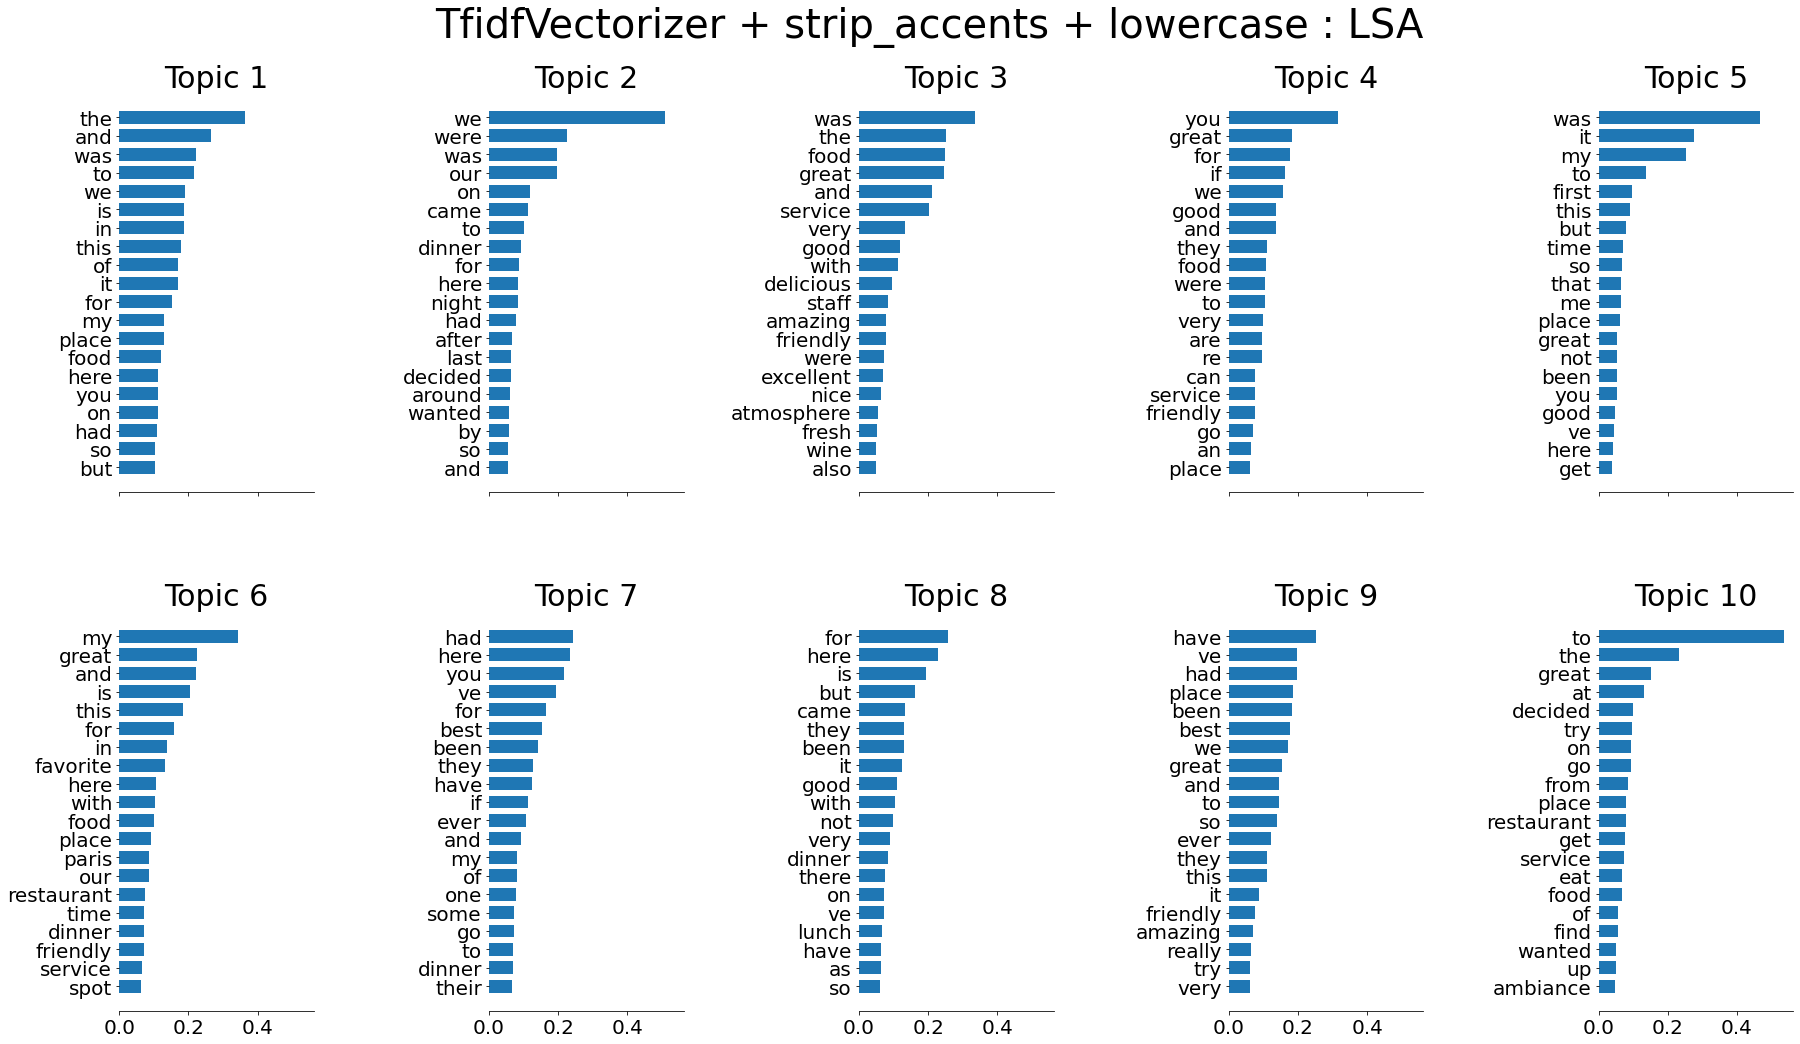

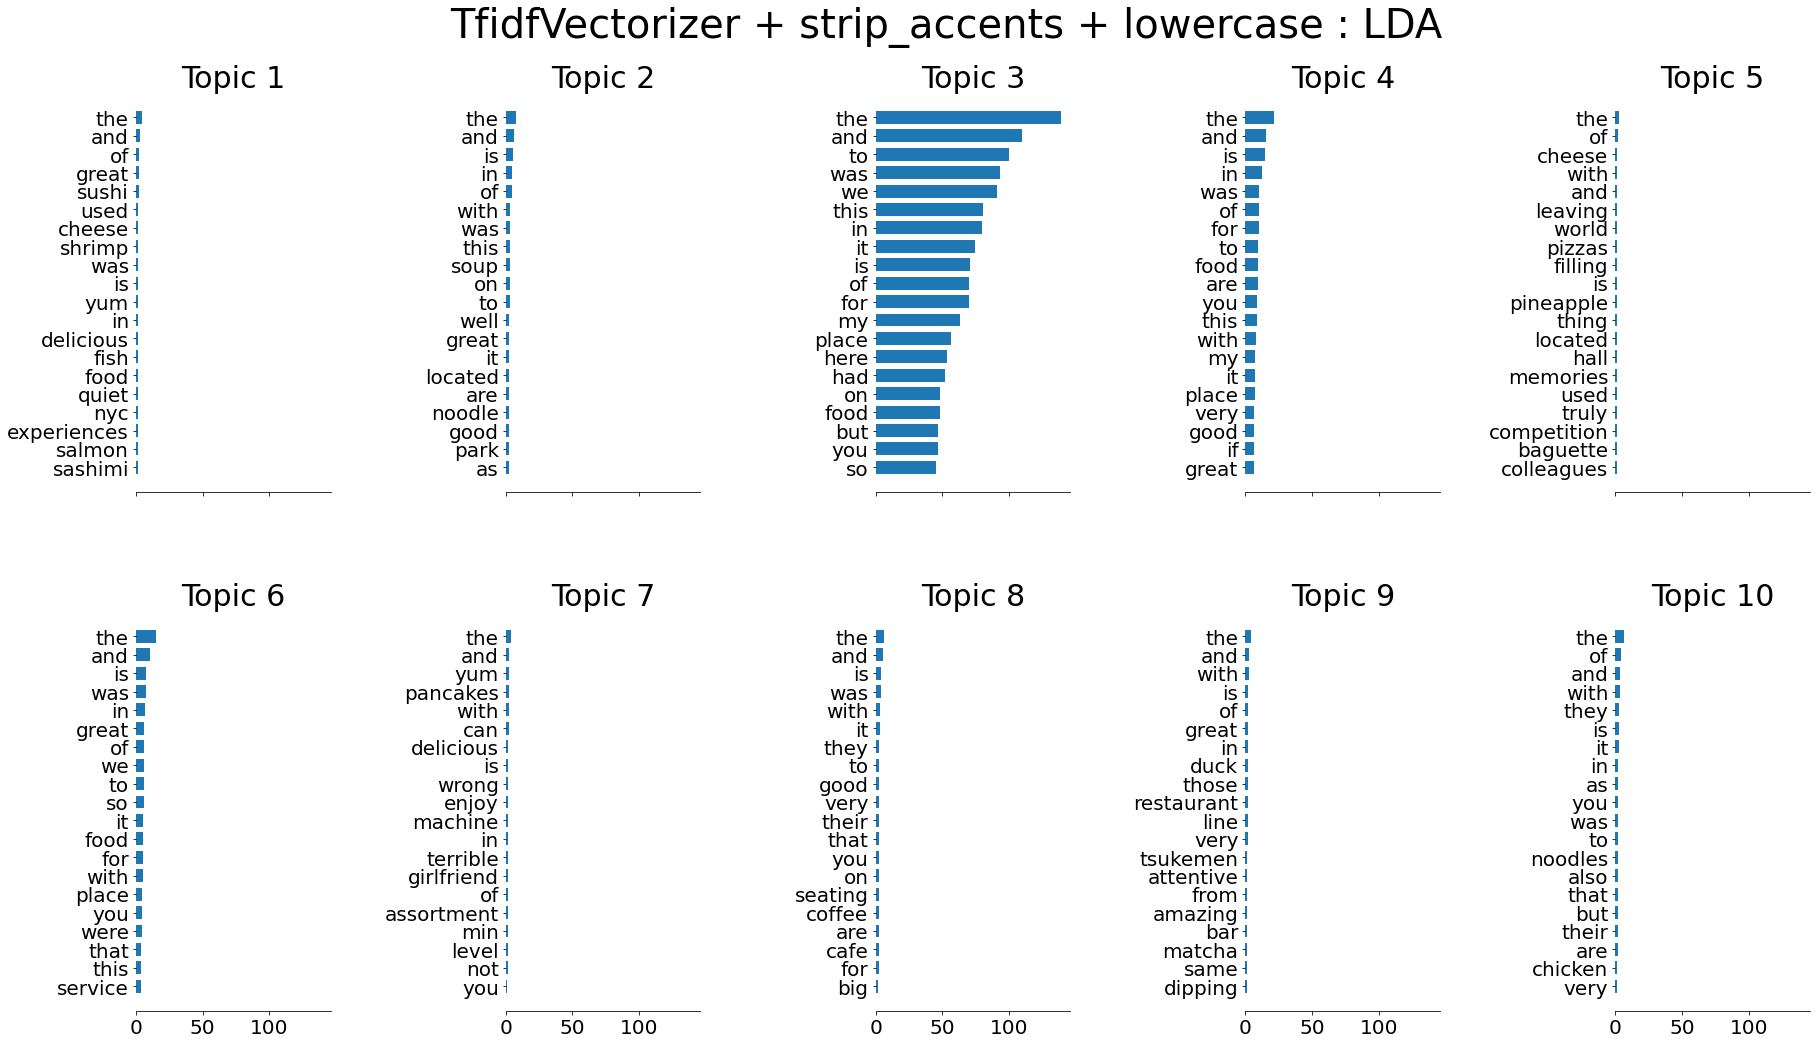

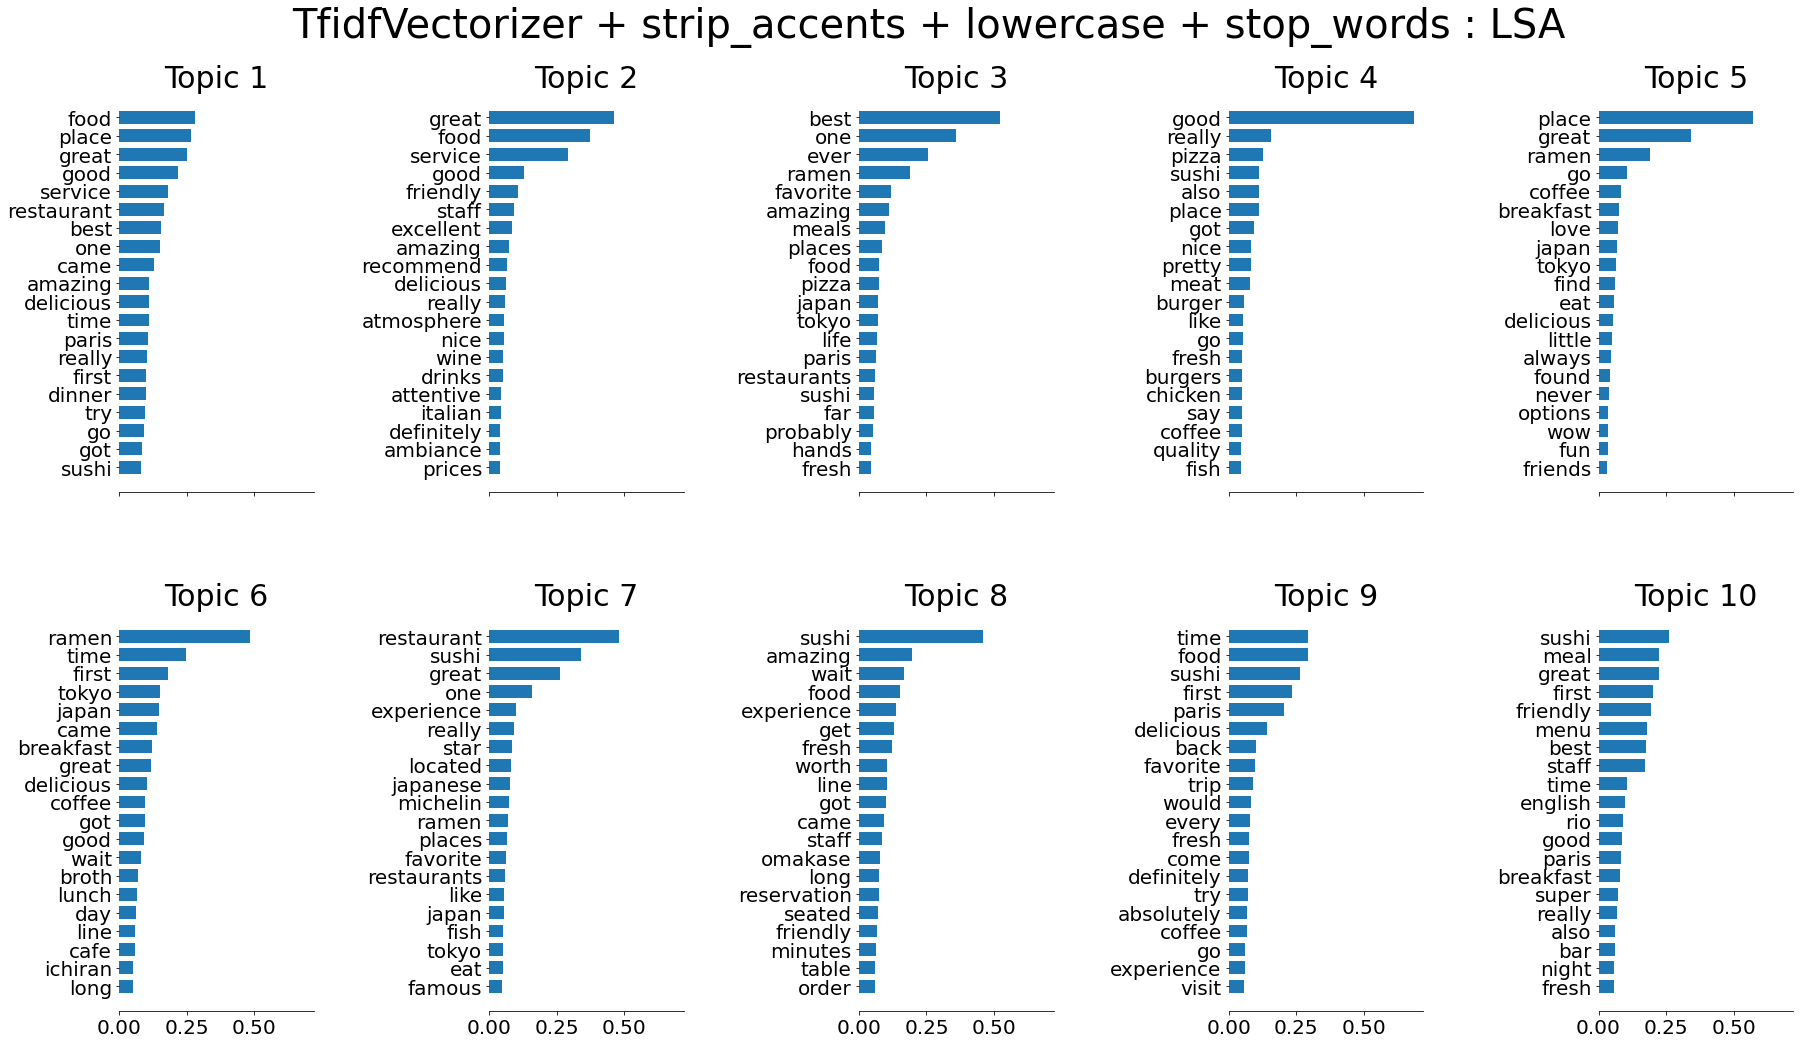

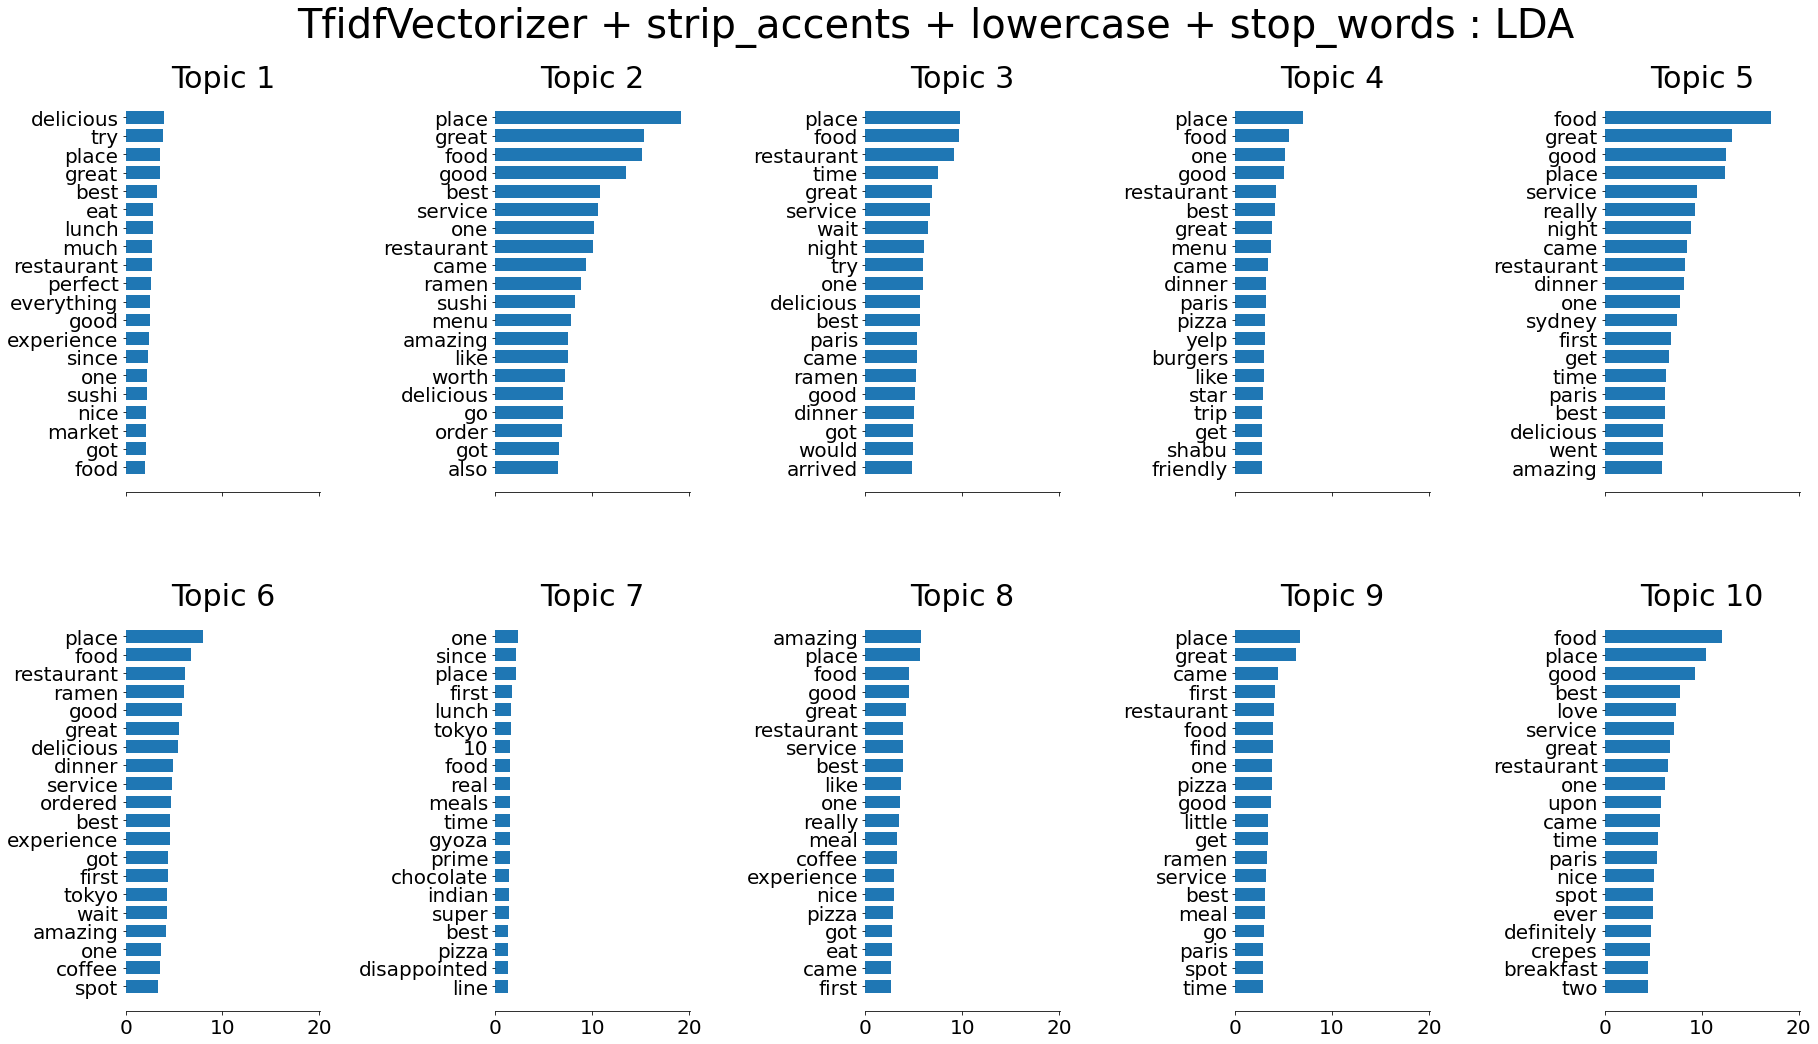

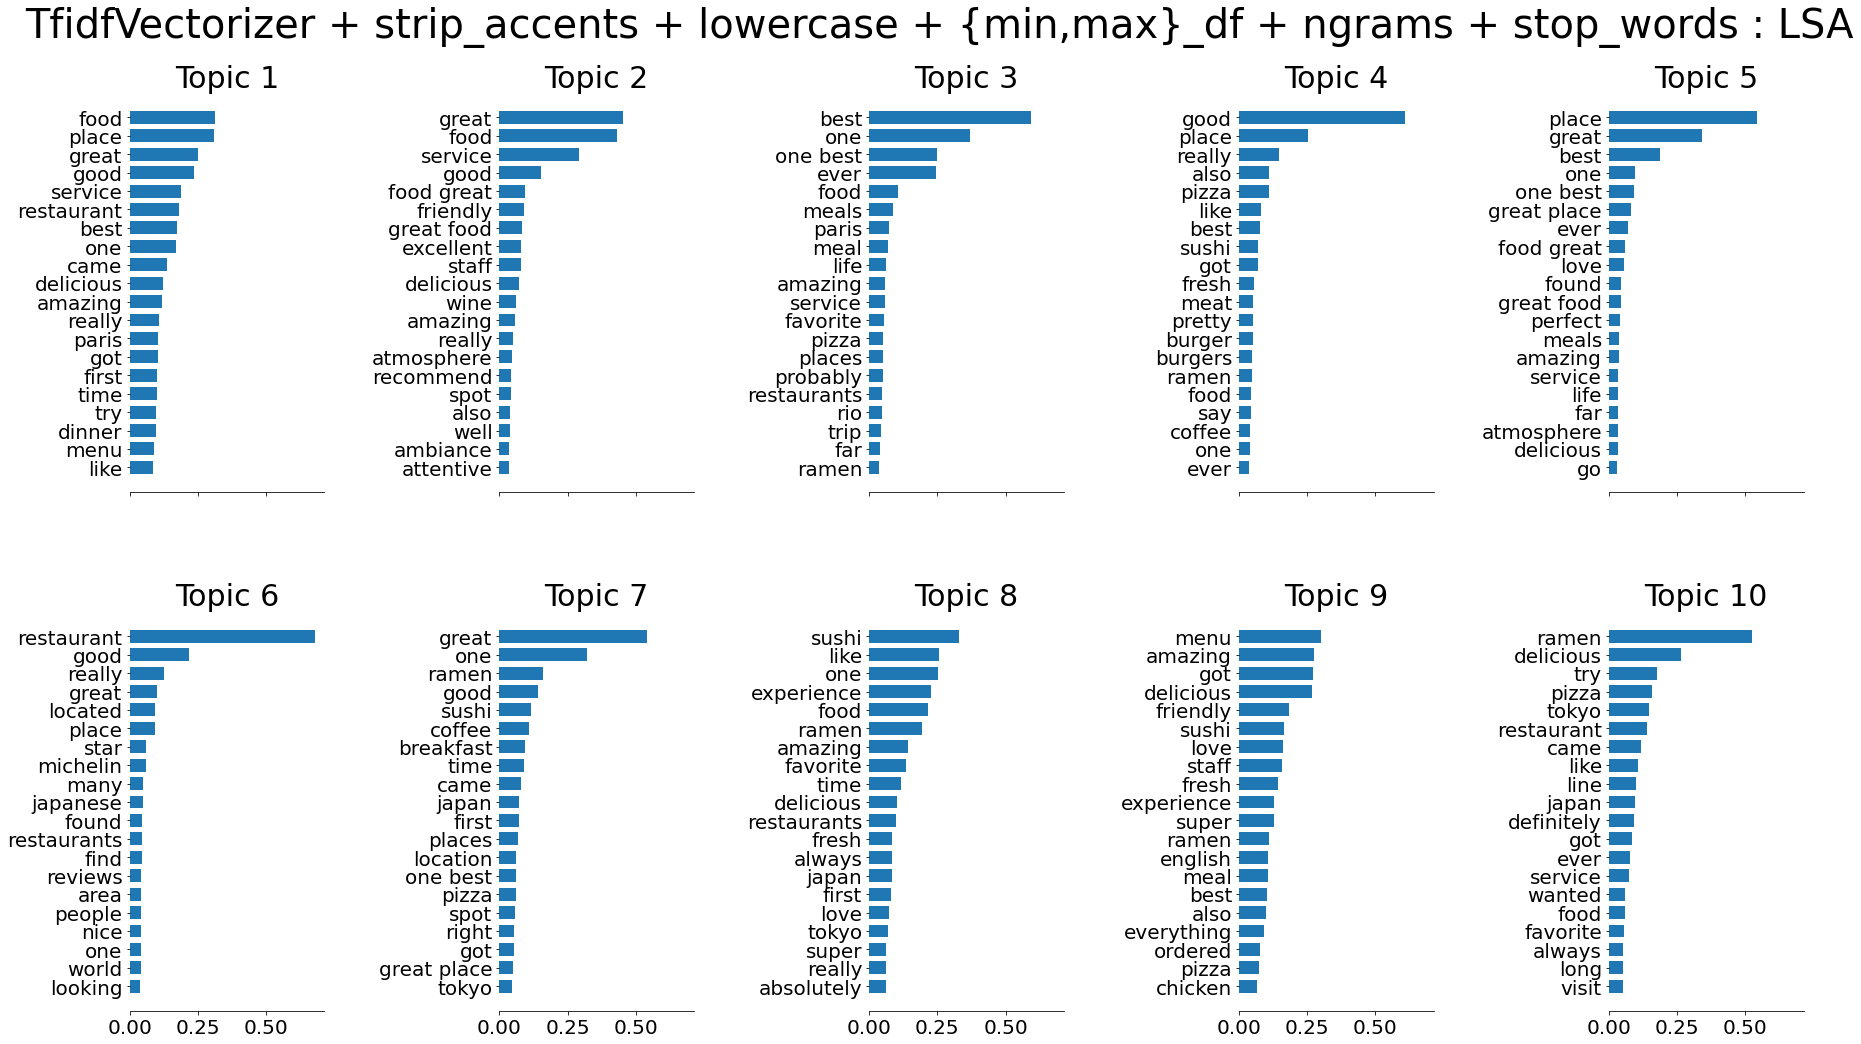

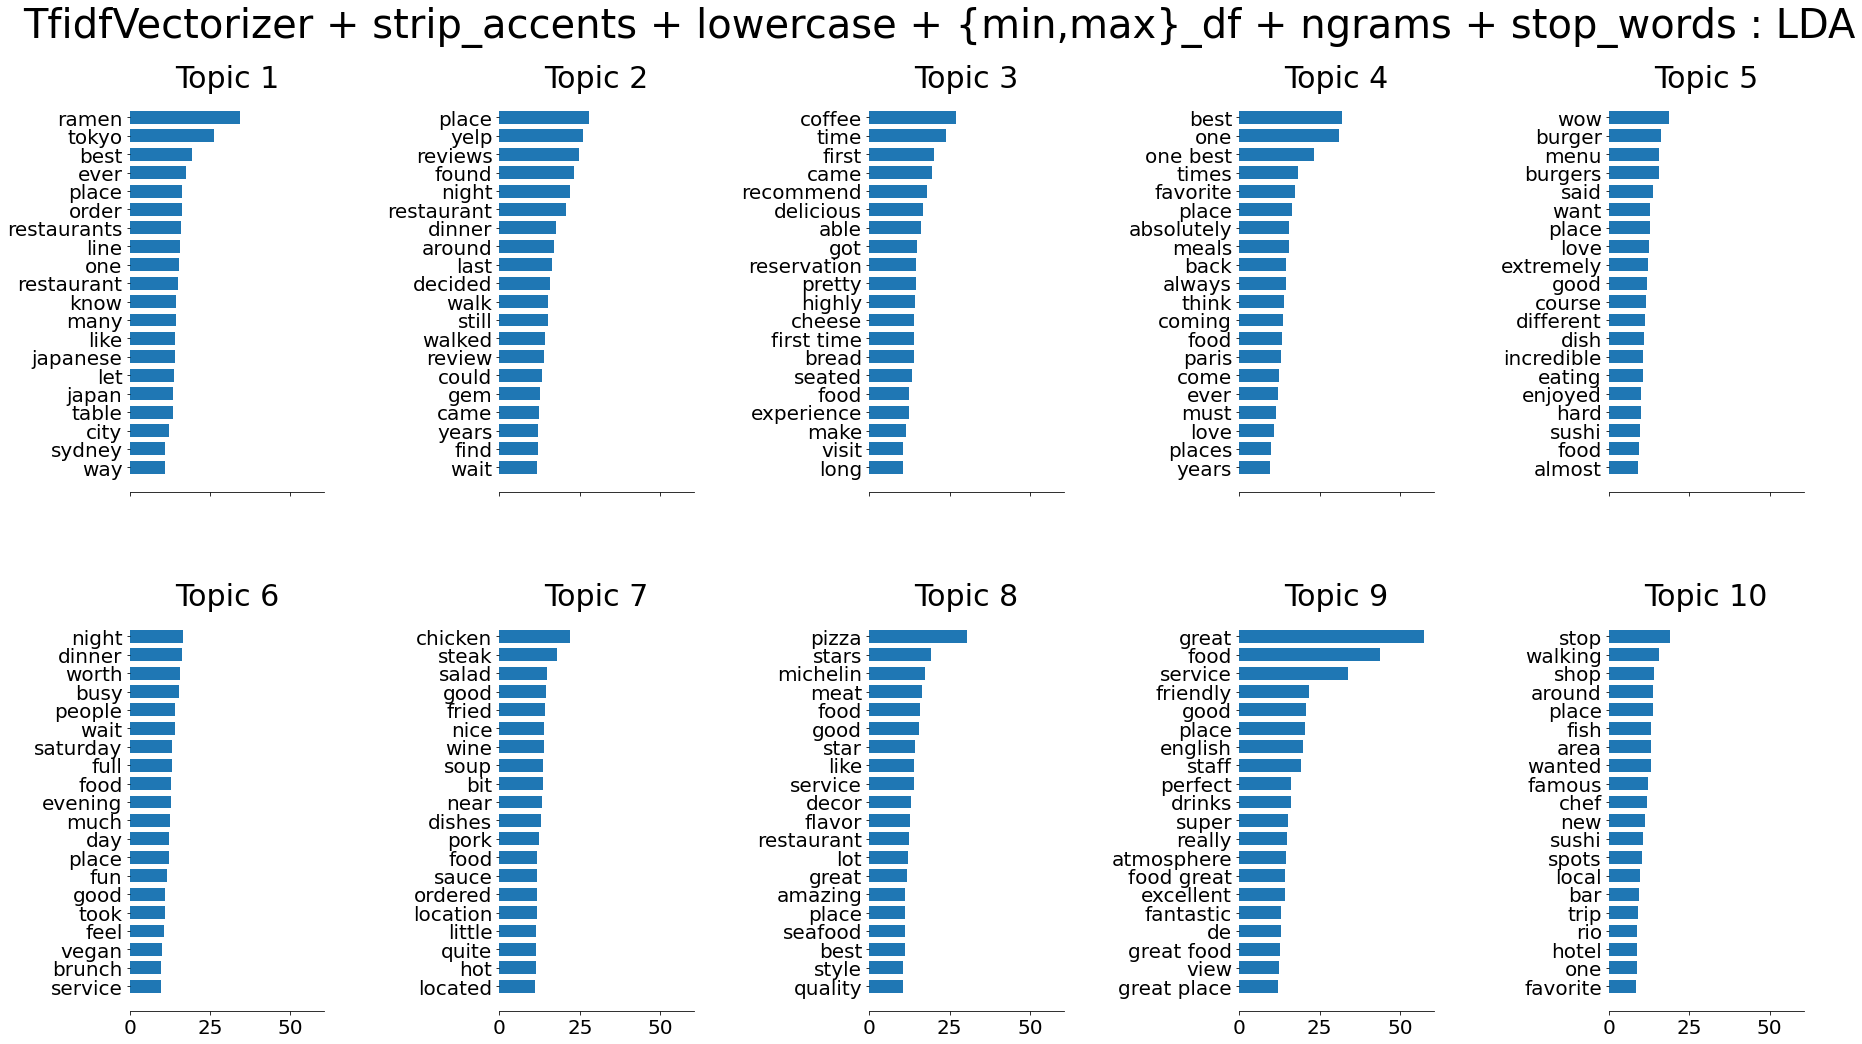

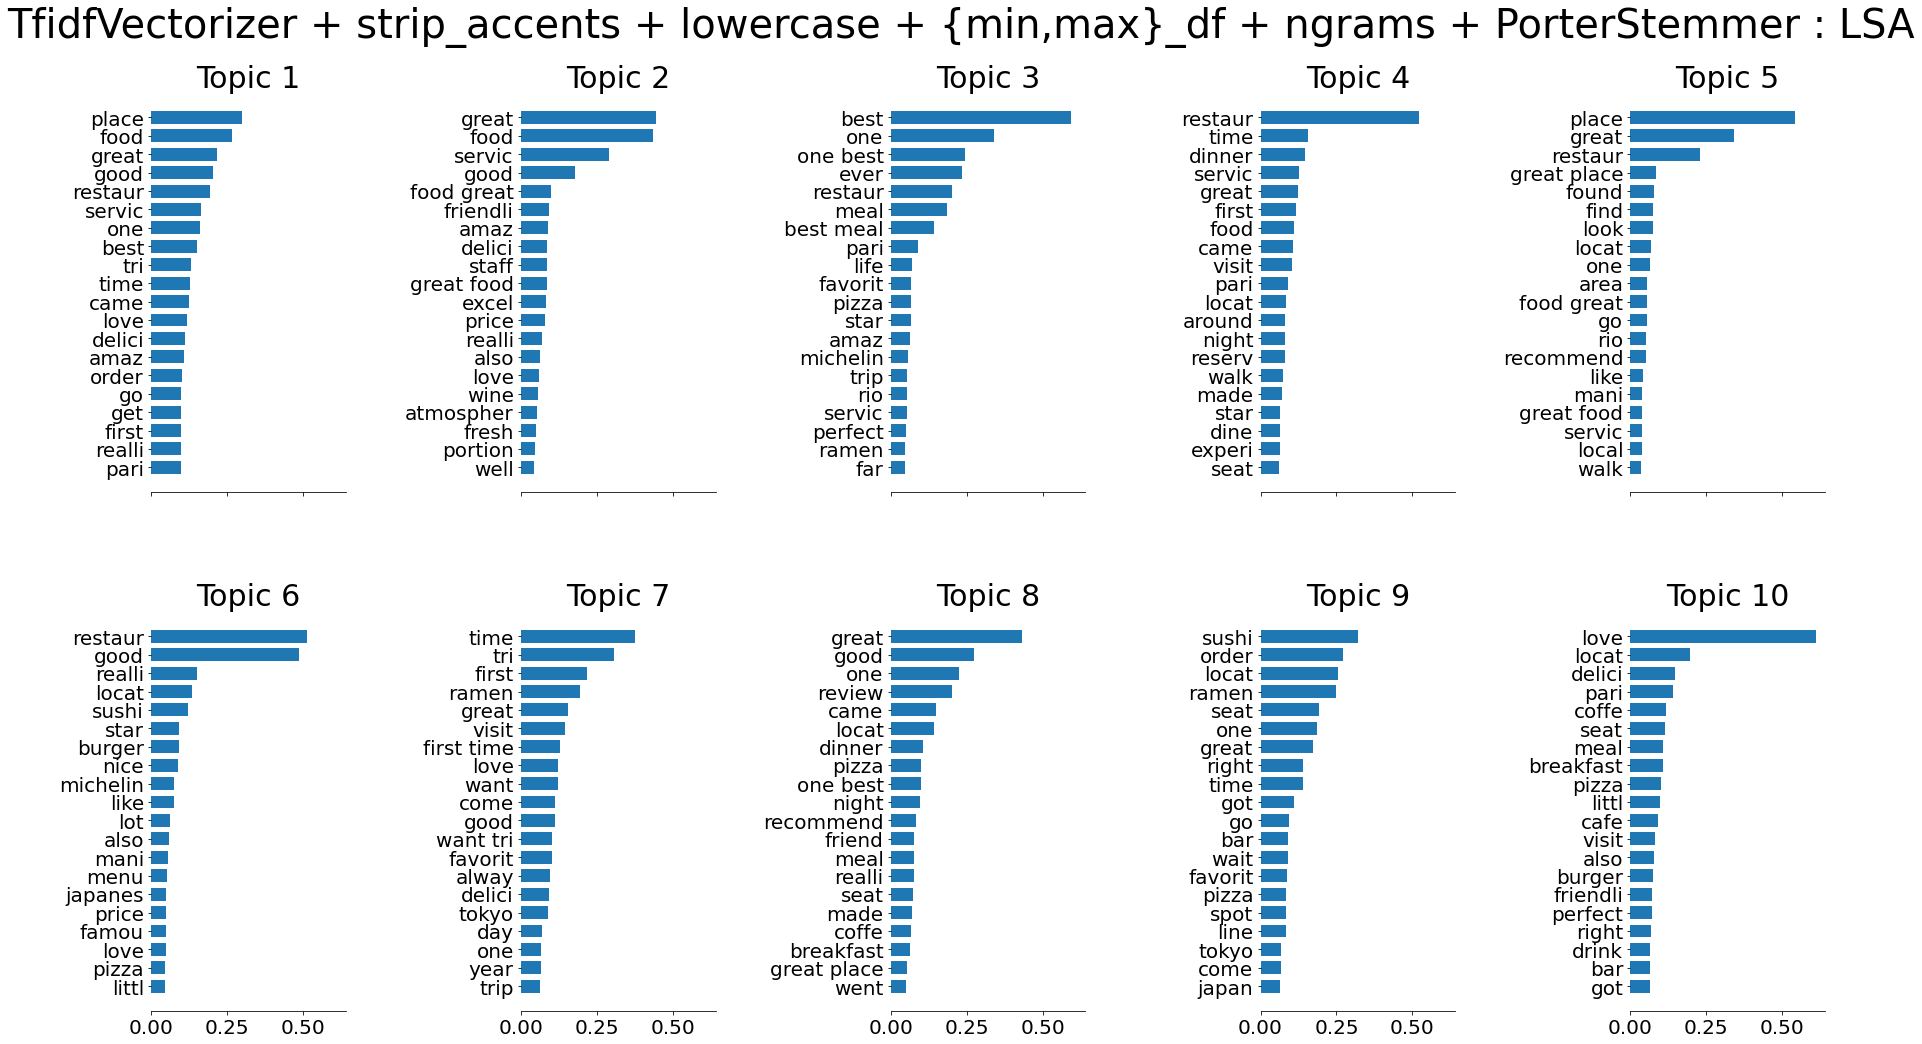

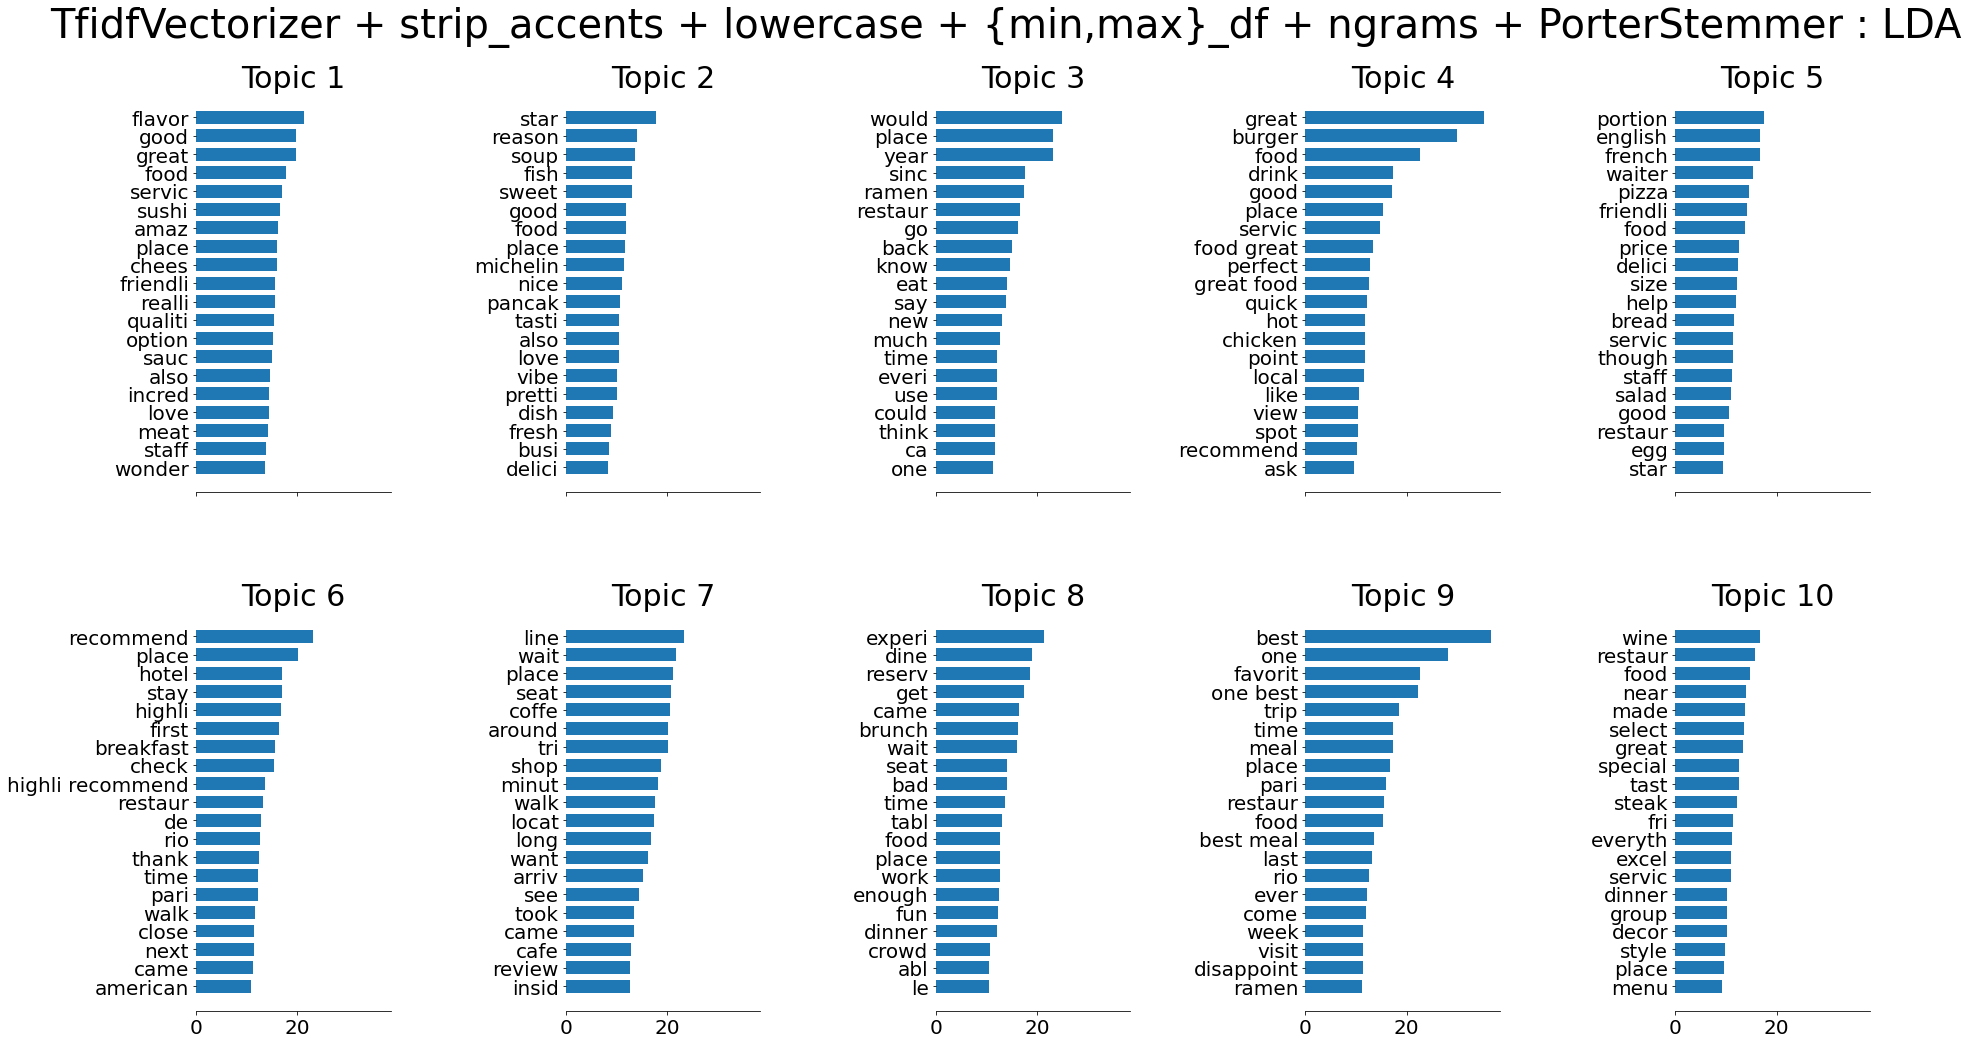

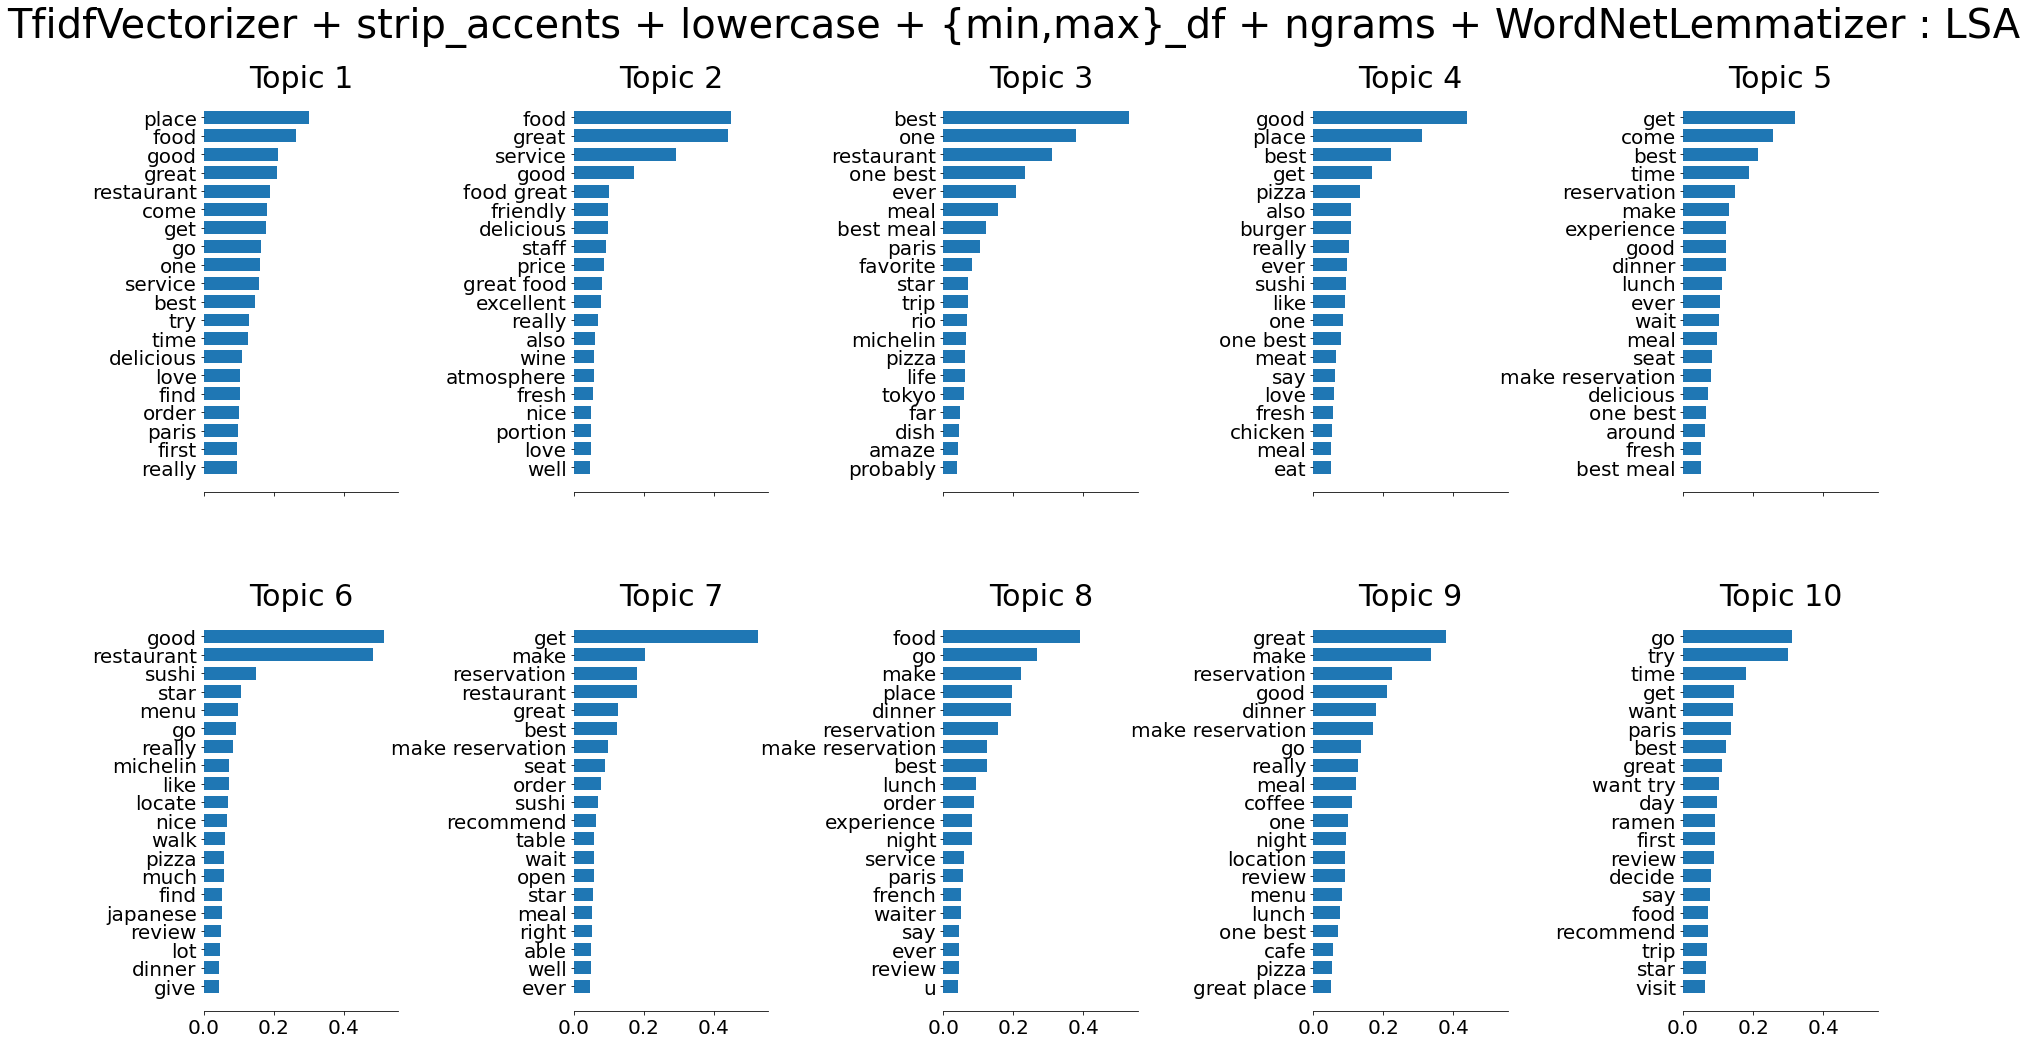

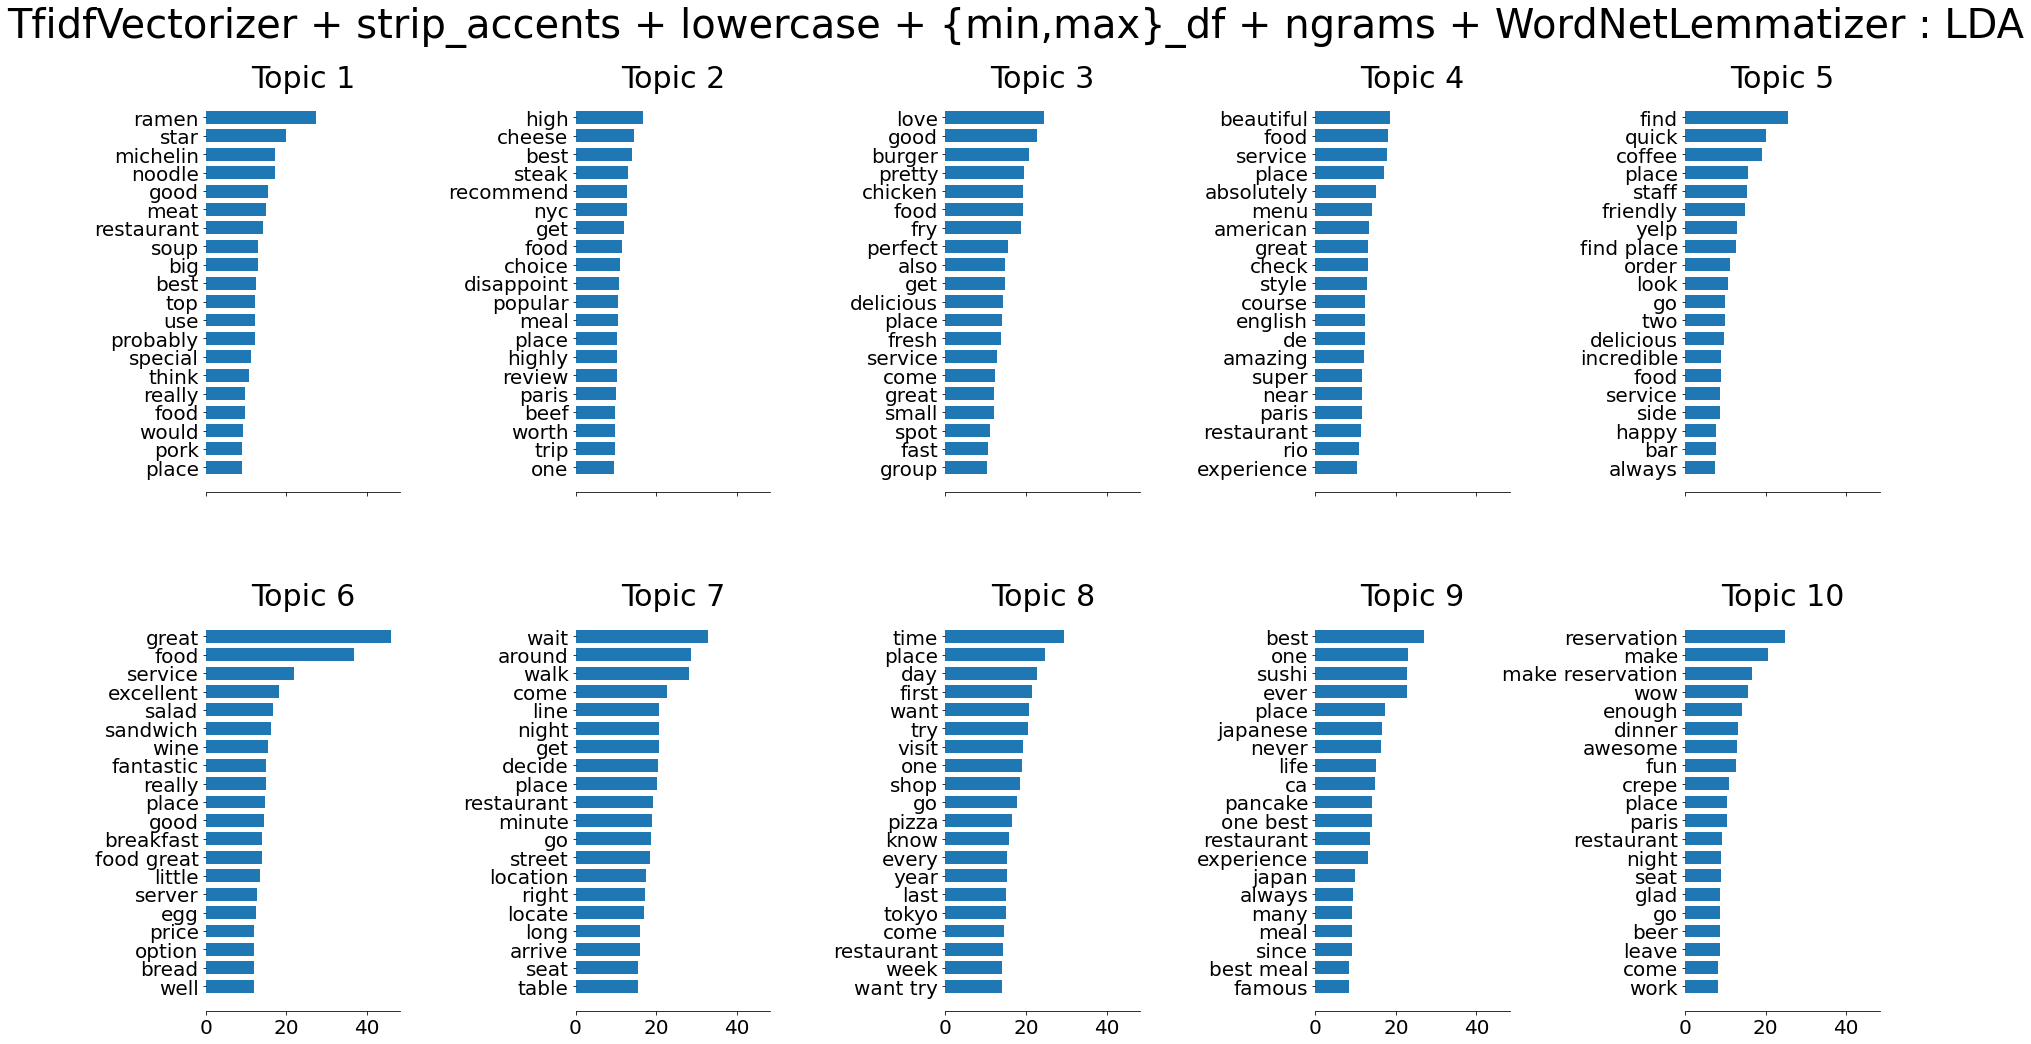

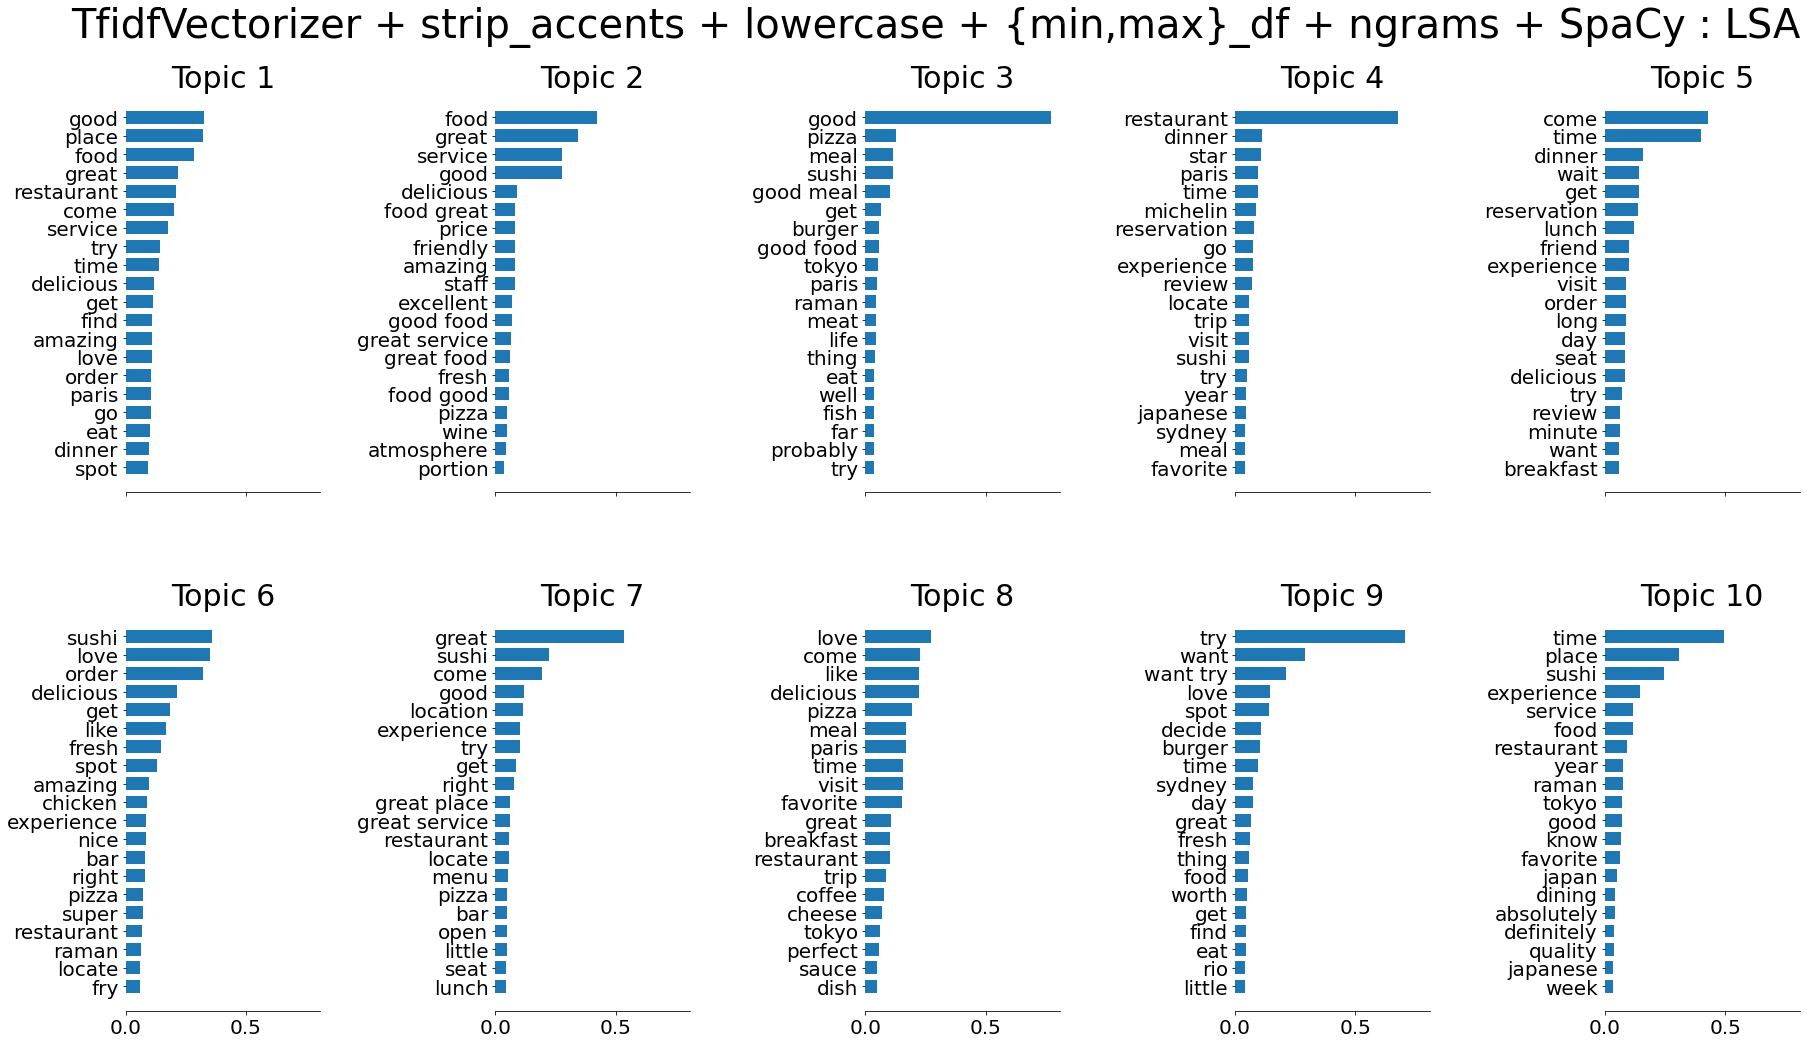

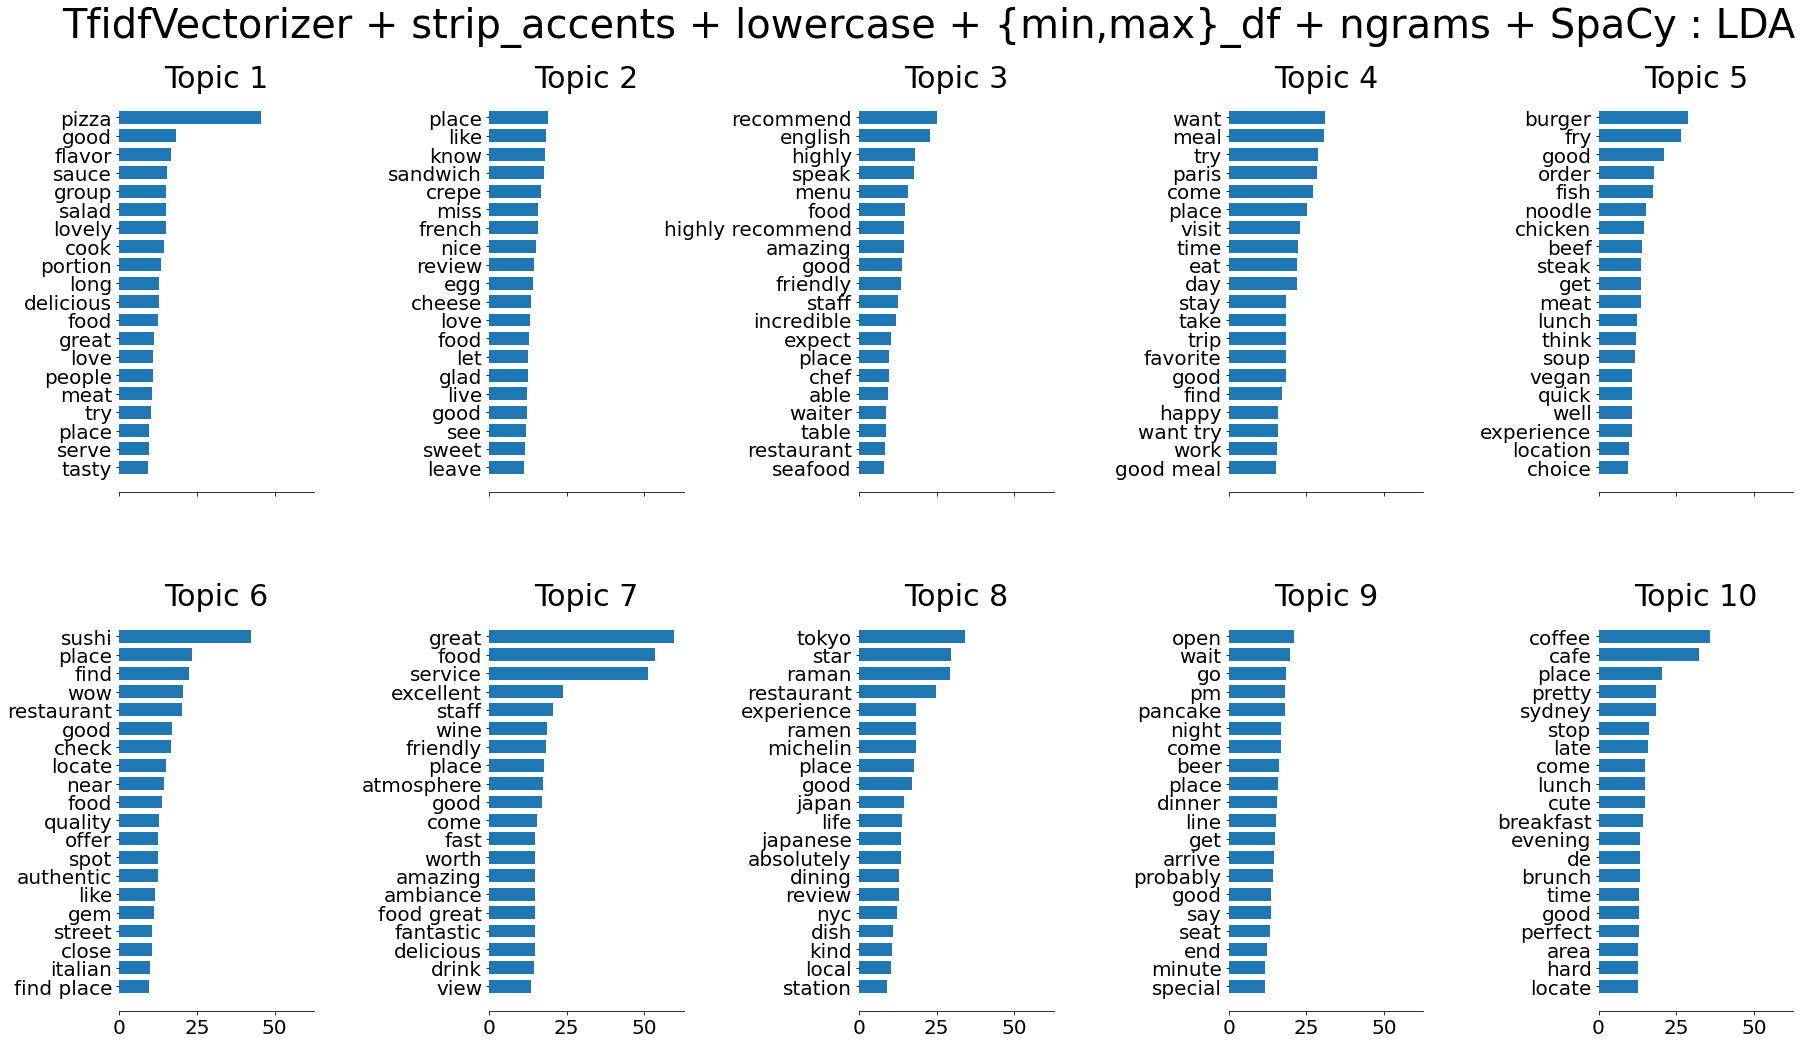

In [79]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation


def plot_top_words(model, feature_names, n_top_words, title):
    n_cols = 5
    n_lines = int(np.ceil(model.n_components / n_cols))
    fig, axes = plt.subplots(n_lines, n_cols, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[0 : n_lines * n_cols]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


n_components = 10
for vectorizer_name in [
    "TfidfVectorizer + strip_accents + lowercase",
    "TfidfVectorizer + strip_accents + lowercase + stop_words",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + stop_words",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + PorterStemmer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + WordNetLemmatizer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + SpaCy",
]:
    vectorizer = vectorizers[vectorizer_name]
    X_vec = vectorizer.fit_transform(X)

    words_count = pd.Series(
        X_vec.sum(axis=0).tolist()[0],
        index=vectorizer.get_feature_names(),
    )

    top_20_count = words_count.sort_values(ascending=False).head(20)

    fig = px.bar(
        top_20_count,
        x=top_20_count.index,
        y=top_20_count.values,
        labels={"x": "Word", "y": "Count"},
        title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
        color=top_20_count.values,
    )
    fig.show()

    lsa = TruncatedSVD(n_components=n_components, random_state=42)
    X_lsa = lsa.fit_transform(X_vec)

    fig = px.line(
        x=range(1, n_components + 1),
        y=np.cumsum(lsa.explained_variance_ratio_),
        labels={
            "x": "Principal Component",
            "y": "Explained Variance Ratio",
        },
        title=f"{vectorizer_name} : Explained Variance Ratio",
    )
    fig.show()

    fig = px.scatter_3d(
        X_lsa,
        x=X_lsa[:, 0],
        y=X_lsa[:, 1],
        z=X_lsa[:, 2],
        labels={"x": "Component 1", "y": "Component 2", "z": "Component 3"},
        title=f"{vectorizer_name} : SVD (R² = {round(results_reg_df.loc[results_reg_df['vectorizer'] == vectorizer_name]['r2_score'].values[0], 3)}, ROC_AUC = {round(results_cls_df.loc[results_reg_df['vectorizer'] == vectorizer_name]['roc_auc_score'].values[0], 3)})",
        color=y,
        opacity=0.5,
    )
    fig.show()

    plot_top_words(
        lsa, vectorizer.get_feature_names(), 20, f"{vectorizer_name} : LSA"
    )

    lda = LatentDirichletAllocation(
        n_components=n_components,
        random_state=42,
        n_jobs=-1,
    )
    X_lda = lda.fit_transform(X_vec)

    plot_top_words(
        lda, vectorizer.get_feature_names(), 20, f"{vectorizer_name} : LDA"
    )


### Word Embedding
